In [1]:
#Data handling
import h5py
#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import sys


#Mathematical libraries
import numpy as np
import pandas as pd

import pickle
import subprocess
import itertools

In [3]:
data = pd.read_csv('cath-b-newest-all.txt', sep=" ", header=None)
data.columns = ["pdb_chain_domain", "version", "cath", "residues"]

In [4]:
data

pdb_chain_domain   version         cath  \
0               101mA00    v4_2_0  1.10.490.10   
1               102lA00    v4_2_0  1.10.530.40   
2               102mA00    v4_2_0  1.10.490.10   
3               103lA00    v4_2_0  1.10.530.40   
4               103mA00    v4_2_0  1.10.490.10   
...                 ...       ...          ...   
527903          7bwgA02  putative   3.20.20.80   
527904          7bwgB02  putative   3.20.20.80   
527905          7bwpA01  putative   3.50.50.60   
527906          7bwpA02  putative  3.30.410.40   
527907          7byzA00  putative  1.10.640.10   

                                     residues  
0                                     0-153:A  
1                                     1-162:A  
2                                     0-153:A  
3                                     1-162:A  
4                                     0-153:A  
...                                       ...  
527903                              138-478:A  
527904                              138-478:B  
527905  9-146:A,192-298:A,368-390:A,458-519:A  
527906          147-191:A,299-367:A,391-457:A  
527907                                1-595:A  

[527908 rows x 4 columns]

In [2]:
df = pd.read_hdf('/data/lohia/EGAD_analysis/3d_pred/gene3dout.hdf5', 'nw') #this was the file written from api
df = pd.concat([df.drop(['metadata'], axis=1), df['metadata'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop(['evidences'], axis=1), df['evidences'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop(['source'], axis=1), df['source'].apply(pd.Series)], axis=1)
df = df.loc[df['type'] == 'PREDICTED_DOMAIN']
df_cath_prediction = df[df['resource'].isin(['pDomTHREADER'])]
df_cath_prediction['loc_length'] = [i[0]['fragments'][0]['end'] - i[0]['fragments'][0]['start'] + 1 for i in df_cath_prediction['locations']]
#df_cath_prediction = df[df['resource'].isin(['FUGUE (CATH-based)', 'Gene3D', 'pDomTHREADER'])]
df_cath_prediction.drop(columns=['length', 'tooltipContent', 'anno_id', 'type', 'code', 'name', 'url'], inplace=True)
df_cath_prediction['confidence'] = df_cath_prediction['confidence'].astype('int')
df_cath_prediction = df_cath_prediction[(df_cath_prediction['confidence'] > 95) & (df_cath_prediction['loc_length'] > 30)]

/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [5]:
df_cath_prediction

accession                                      locations  confidence  \
25    P00519   [{'fragments': [{'end': 121, 'start': 64}]}]         100   
26    P00519  [{'fragments': [{'end': 224, 'start': 127}]}]         100   
27    P00519  [{'fragments': [{'end': 317, 'start': 225}]}]         100   
28    P00519  [{'fragments': [{'end': 491, 'start': 318}]}]         100   
29    P00519  [{'fragments': [{'end': 995, 'start': 569}]}]         100   
..       ...                                            ...         ...   
24    Q7Z443   [{'fragments': [{'end': 141, 'start': 25}]}]         100   
27    Q7Z443  [{'fragments': [{'end': 851, 'start': 738}]}]         100   
9     Q8IV16   [{'fragments': [{'end': 148, 'start': 74}]}]          99   
9     P32745   [{'fragments': [{'end': 330, 'start': 18}]}]         100   
1     Q2M3D2    [{'fragments': [{'end': 350, 'start': 1}]}]          99   

        resource       id  loc_length  
25  pDomTHREADER  2ablA01          58  
26  pDomTHREADER  1opkA02          98  
27  pDomTHREADER  1opjA01          93  
28  pDomTHREADER  2hziA02         174  
29  pDomTHREADER  1s58A00         427  
..           ...      ...         ...  
24  pDomTHREADER  1eggA00         117  
27  pDomTHREADER  1ca1A02         114  
9   pDomTHREADER  2j8bA00          75  
9   pDomTHREADER  1hzxB00         313  
1   pDomTHREADER  1qgrA00         350  

[13086 rows x 6 columns]

In [6]:
#This merge is to limit domains whose residue informtion is present in cath file
merged_left = pd.merge(left=df_cath_prediction, right=data, how='left', left_on='id', right_on='pdb_chain_domain')
merged_left.dropna(subset=['cath'], inplace=True)

In [6]:
#for now I won't be doing this step
#idx = merged_left.groupby(['accession'])['loc_length'].transform(max) == merged_left['loc_length'] #represents each protein with maximum length id
#merged_left = merged_left[idx]

In [8]:
merged_left['pdb'] = merged_left['pdb_chain_domain'].str[:4] # removing extra characters in protein name
merged_left['chain'] = merged_left['pdb_chain_domain'].str[4:5]
merged_left['pdb_chain'] = merged_left['pdb'] + '_' + merged_left['chain']

In [7]:
new=merged_left['cath'].str.split(".", n = 3, expand = True)  # expand the cath domains
merged_left['cat'] = new[0] + '.' + new[1] + '.' + new[2]

In [20]:
merged_left['c'] = new[0]

In [22]:
merged_left

accession                                      locations  confidence  \
0        P00519   [{'fragments': [{'end': 121, 'start': 64}]}]         100   
1        P00519  [{'fragments': [{'end': 224, 'start': 127}]}]         100   
2        P00519  [{'fragments': [{'end': 317, 'start': 225}]}]         100   
3        P00519  [{'fragments': [{'end': 491, 'start': 318}]}]         100   
4        P00519  [{'fragments': [{'end': 995, 'start': 569}]}]         100   
...         ...                                            ...         ...   
13081    Q7Z443   [{'fragments': [{'end': 141, 'start': 25}]}]         100   
13082    Q7Z443  [{'fragments': [{'end': 851, 'start': 738}]}]         100   
13083    Q8IV16   [{'fragments': [{'end': 148, 'start': 74}]}]          99   
13084    P32745   [{'fragments': [{'end': 330, 'start': 18}]}]         100   
13085    Q2M3D2    [{'fragments': [{'end': 350, 'start': 1}]}]          99   

           resource       id  loc_length pdb_chain_domain version  \
0      pDomTHREADER  2ablA01          58          2ablA01  v4_2_0   
1      pDomTHREADER  1opkA02          98          1opkA02  v4_2_0   
2      pDomTHREADER  1opjA01          93          1opjA01  v4_2_0   
3      pDomTHREADER  2hziA02         174          2hziA02  v4_2_0   
4      pDomTHREADER  1s58A00         427          1s58A00  v4_2_0   
...             ...      ...         ...              ...     ...   
13081  pDomTHREADER  1eggA00         117          1eggA00  v4_2_0   
13082  pDomTHREADER  1ca1A02         114          1ca1A02  v4_2_0   
13083  pDomTHREADER  2j8bA00          75          2j8bA00  v4_2_0   
13084  pDomTHREADER  1hzxB00         313          1hzxB00  v4_2_0   
13085  pDomTHREADER  1qgrA00         350          1qgrA00  v4_2_0   

               cath   residues        cat  c  
0        2.30.30.40   75-140:A    2.30.30  2  
1       3.30.505.10  146-247:A   3.30.505  3  
2       3.30.200.20  243-336:A   3.30.200  3  
3       1.10.510.10  318-500:A   1.10.510  1  
4       2.170.30.10   19-554:A   2.170.30  2  
...             ...        ...        ... ..  
13081   3.10.100.10  628-763:A   3.10.100  3  
13082    2.60.60.20  251-370:A    2.60.60  2  
13083    2.10.60.10     0-77:A    2.10.60  2  
13084  1.20.1070.10    1-326:B  1.20.1070  1  
13085    1.25.10.10    1-876:A    1.25.10  1  

[13049 rows x 12 columns]

In [9]:
merged_left['cat'].nunique()

534

In [23]:
cat_list = merged_left['cat'].unique().tolist()

In [24]:
accession_domid = merged_left.groupby(['accession']).agg({'cat': lambda x: list(set(x)), 'c': lambda x: list(set(x))})

In [25]:
accession_domid

cat       c
accession                                      
A0AV96                        [3.30.70]     [3]
A0AVF1                        [1.25.40]     [1]
A0AVI2                        [2.60.40]     [2]
A0AVK6              [1.10.10, 2.170.30]  [2, 1]
A0FGR8                        [2.60.40]     [2]
...                                 ...     ...
Q9Y6X9                       [3.30.565]     [3]
Q9Y6Y0             [2.120.10, 3.30.710]  [2, 3]
Q9Y6Y1     [2.60.40, 2.170.30, 1.25.40]  [2, 1]
Q9Y6Y8             [1.10.150, 2.170.30]  [2, 1]
Q9Y6Y9                        [2.60.40]     [2]

[6533 rows x 2 columns]

In [30]:
#the generated file is used to run vmd locally, I downlaod all the pdb domain required
with open('domain_id.txt', 'wb') as fp:
    pickle.dump(list(set(merged_left['pdb_chain_domain'].tolist())), fp)

#after this step all the generated pdb files are synced back to rugen12 from my local machine

In [26]:
exp = pd.read_hdf('/data/lohia/EGAD_analysis/3d_pred/filtered_exp.hdf5', 'nw') #this was the file written from api
subset_cols = list (set(exp.index) & set(merged_left.accession))
exp = exp.loc[subset_cols, subset_cols]

long_form = exp.unstack()
long_form.index.rename(['col_1', 'col_2'], inplace=True)
long_form = long_form.to_frame('exp').reset_index()

In [27]:
exp

Q8TEH3    Q9UJ96    Q8TBK2    P49767    Q9UHL4    Q9NV35    O15393  \
Q8TEH3  0.999932  0.687588  0.723783  0.414139  0.879715  0.726570  0.205897   
Q9UJ96  0.687588  0.999932  0.428535  0.107369  0.582088  0.158956  0.009768   
Q8TBK2  0.723783  0.428535  0.999932  0.379191  0.792432  0.942472  0.101809   
P49767  0.414139  0.107369  0.379191  0.999932  0.426260  0.400225  0.252964   
Q9UHL4  0.879715  0.582088  0.792432  0.426260  0.999932  0.761686  0.046861   
...          ...       ...       ...       ...       ...       ...       ...   
P98164  0.186479  0.042428  0.097469  0.091770  0.037510  0.034482  0.155448   
Q10586  0.828307  0.532873  0.761797  0.196702  0.848998  0.659213  0.012029   
Q13253  0.287641  0.244765  0.518572  0.223519  0.602020  0.498254  0.016104   
P49354  0.789414  0.272510  0.940176  0.534930  0.828150  0.980895  0.130189   
Q96LD4  0.612026  0.258716  0.628481  0.514464  0.906553  0.615663  0.100384   

          Q9Y689    O75084    Q9NP71  ...    P61769    O75323    Q6UXE8  \
Q8TEH3  0.676356  0.543028  0.559480  ...  0.622785  0.819419  0.199414   
Q9UJ96  0.249814  0.155786  0.255006  ...  0.034460  0.233325  0.015794   
Q8TBK2  0.932093  0.644750  0.380924  ...  0.406741  0.876635  0.052219   
P49767  0.480013  0.469217  0.099855  ...  0.530242  0.481819  0.151082   
Q9UHL4  0.663669  0.604459  0.484998  ...  0.779465  0.813782  0.036680   
...          ...       ...       ...  ...       ...       ...       ...   
P98164  0.077094  0.021587  0.035090  ...  0.063224  0.032176  0.039976   
Q10586  0.698933  0.485169  0.431676  ...  0.435826  0.742693  0.034114   
Q13253  0.555891  0.356265  0.034682  ...  0.300136  0.535087  0.016839   
P49354  0.957591  0.703967  0.188717  ...  0.875762  0.953616  0.038628   
Q96LD4  0.546634  0.719428  0.297884  ...  0.602956  0.574932  0.024419   

          Q8TEK3    Q9UKJ0    P98164    Q10586    Q13253    P49354    Q96LD4  
Q8TEH3  0.866432  0.522989  0.186479  0.828307  0.287641  0.789414  0.612026  
Q9UJ96  0.644236  0.326988  0.042428  0.532873  0.244765  0.272510  0.258716  
Q8TBK2  0.820946  0.786524  0.097469  0.761797  0.518572  0.940176  0.628481  
P49767  0.432532  0.192749  0.091770  0.196702  0.223519  0.534930  0.514464  
Q9UHL4  0.885185  0.685291  0.037510  0.848998  0.602020  0.828150  0.906553  
...          ...       ...       ...       ...       ...       ...       ...  
P98164  0.110050  0.023021  0.999932  0.015306  0.011889  0.160487  0.010794  
Q10586  0.719603  0.676282  0.015306  0.999932  0.570944  0.770482  0.613801  
Q13253  0.327125  0.261169  0.011889  0.570944  0.999932  0.612446  0.478622  
P49354  0.788378  0.725041  0.160487  0.770482  0.612446  0.999932  0.732491  
Q96LD4  0.781386  0.511364  0.010794  0.613801  0.478622  0.732491  0.999932  

[6187 rows x 6187 columns]

In [28]:
accession_domid = accession_domid.loc[subset_cols, :]

In [29]:
long_form

col_1   col_2       exp
0         Q8TEH3  Q8TEH3  0.999932
1         Q8TEH3  Q9UJ96  0.687588
2         Q8TEH3  Q8TBK2  0.723783
3         Q8TEH3  P49767  0.414139
4         Q8TEH3  Q9UHL4  0.879715
...          ...     ...       ...
38278964  Q96LD4  P98164  0.010794
38278965  Q96LD4  Q10586  0.613801
38278966  Q96LD4  Q13253  0.478622
38278967  Q96LD4  P49354  0.732491
38278968  Q96LD4  Q96LD4  0.999932

[38278969 rows x 3 columns]

In [16]:
#uni_pdb = dict(zip(merged_left.accession,merged_left.pdb))
#uni_pdbdomain = dict(zip(merged_left.accession,merged_left.pdb_chain_domain))
unip_pdbdomain = dict(zip(accession_domid.index,accession_domid.pdb_chain_domain)) #this is a tupled list of uniprot id and domain_id
#print (uni_pdbdomain.values())
#uni_pdbdomain = list(zip(merged_left.accession,merged_left.pdb_chain_domain)) #this is a tupled list of uniprot id and domain_id

#print (uni_pdbdomain)
#uni_pdb_chain =  dict(zip(merged_left.accession,merged_left.pdb_chain))

#new=merged_left['cath'].str.split(".", n = 3, expand = True)  # expand the cath domains
#merged_left['cat'] = new[0] + '.' + new[1] + '.' + new[2]
#merged_left_uniq_domain = merged_left.drop_duplicates(subset=['pdb_chain_domain'])

#domain_cath =  dict(zip(merged_left_uniq_domain.pdb_chain_domain,merged_left_uniq_domain.cat))

#uni_id = list(set(list(exp.index.values)))

#domain_uniq= [uni_pdbdomain[y] for y in uni_id]
#domain_uniq = ([x[1] for x in uni_pdbdomain if x[0] in uni_id]) #filtering only the list present in my exp table
unip_pairs = list(itertools.combinations(unip_pdbdomain.values(),2)) #this gets all the unique combination of lists


In [17]:
dom_pairs = [sorted(list(itertools.product(x[0], x[1]))) for x in unip_pairs]

In [18]:
dom_pairs_com = [item for sub_list in dom_pairs for item in sub_list]

In [19]:
dom_pairs_sorted =  [tuple(sorted(x)) for x in dom_pairs_com]

In [20]:
dom_pairs_uni = list(set(dom_pairs_sorted))

In [21]:
len(dom_pairs_uni)

4629614

In [27]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
list_chunks = list(chunks(dom_pairs_uni, 180000))

In [28]:
len(list_chunks)

26

In [12]:
id1 = df_domain_pair_tm_score["id1"].tolist()
id2 = df_domain_pair_tm_score["id2"].tolist()
tmscore = df_domain_pair_tm_score["tmscore"].tolist()
df_domain_pair_tm_score_rev = pd.DataFrame({"id1": id2, "id2": id1, "tmscore": tmscore })

In [151]:
#this is done to ensure the overpopulated viral capsid protein is no longer identified as a domain
df_domain_pair_tm_score_rev["tmscore"] = [np.nan if x== '1s58A00' else np.nan if y== '1s58A00' else z for x, y, z in zip(df_domain_pair_tm_score_rev["id1"], df_domain_pair_tm_score_rev["id1"], df_domain_pair_tm_score_rev["tmscore"])]

In [13]:
df_domain_pair_tm_score_identity = pd.DataFrame({"id1": accession_domid.index.tolist(), "id2": accession_domid.index.tolist(), "tmscore": 1 })
df_domain_pair = pd.concat([df_domain_pair_tm_score, df_domain_pair_tm_score_rev, df_domain_pair_tm_score_identity], ignore_index=True)

df_domain_pair['pair'] = df_domain_pair['id1'] + '_' + df_domain_pair['id2']
domainpair_score =  dict(zip(df_domain_pair.pair,df_domain_pair.tmscore))
#dict_items = domainpair_score.items()
#print (list(dict_items)[:2])
#tm_score_domain = [ domainpair_score[uni_pdbdomain[uni_1] + '_' + uni_pdbdomain[uni_2]] for uni_1, uni_2 in zip(long_form['col_1'], long_form['col_2'])]

In [44]:
long_form_dom_1 = pd.merge(left=long_form, right=accession_domid, how='left', left_on='col_1', right_on='accession')

long_form_dom_2 = pd.merge(left=long_form_dom_1, right=accession_domid, how='left', left_on='col_2', right_on='accession')



In [50]:
long_form_dom_2

col_1   col_2       exp       cat_x  c_x  \
0         Q8TEH3  Q8TEH3  0.999932  [2.170.30]  [2]   
1         Q8TEH3  Q9UJ96  0.687588  [2.170.30]  [2]   
2         Q8TEH3  Q8TBK2  0.723783  [2.170.30]  [2]   
3         Q8TEH3  P49767  0.414139  [2.170.30]  [2]   
4         Q8TEH3  Q9UHL4  0.879715  [2.170.30]  [2]   
...          ...     ...       ...         ...  ...   
38278964  Q96LD4  P98164  0.010794   [3.30.40]  [3]   
38278965  Q96LD4  Q10586  0.613801   [3.30.40]  [3]   
38278966  Q96LD4  Q13253  0.478622   [3.30.40]  [3]   
38278967  Q96LD4  P49354  0.732491   [3.30.40]  [3]   
38278968  Q96LD4  Q96LD4  0.999932   [3.30.40]  [3]   

                                                      cat_y        c_y  \
0                                                [2.170.30]        [2]   
1                            [1.20.120, 1.10.287, 3.30.710]     [1, 3]   
2                                    [3.90.1410, 3.90.1420]        [3]   
3                                      [2.10.90, 2.170.300]        [2]   
4                                                 [3.40.50]        [3]   
...                                                     ...        ...   
38278964  [4.10.400, 3.20.20, 2.120.10, 2.170.30, 3.40.7...  [4, 2, 3]   
38278965                                         [1.10.185]        [1]   
38278966                                         [1.10.287]        [1]   
38278967                                          [1.25.40]        [1]   
38278968                                          [3.30.40]        [3]   

          cat_common  1_c  2_c  3_c  4_c  
0         [2.170.30]    0    1    0    0  
1                 []    0    0    0    0  
2                 []    0    0    0    0  
3                 []    0    1    0    0  
4                 []    0    0    0    0  
...              ...  ...  ...  ...  ...  
38278964          []    0    0    1    0  
38278965          []    0    0    0    0  
38278966          []    0    0    0    0  
38278967          []    0    0    0    0  
38278968   [3.30.40]    0    0    1    0  

[38278969 rows x 12 columns]

In [46]:
long_form_dom_2['cat_common'] = [list(set(a) & set(b)) for a,b in zip(long_form_dom_2.cat_x, long_form_dom_2.cat_y)]

In [ ]:
for cat in cat_list:
    long_form_dom_2[cat] = [1 if cat in x else 0 for x in long_form_dom_2['cat_common']]

In [ ]:
#for cat in cat_list:
#    long_form_dom_2[cat] = [1 if cat in list(set(a) & set(b)) else 0 for a,b in zip(long_form_dom_2.cat_x, long_form_dom_2.cat_y)]

In [47]:
long_form_dom_2['1_c'] = [1 if '1' in list(set(a) & set(b)) else 0 for a,b in zip(long_form_dom_2.c_x, long_form_dom_2.c_y)]

In [48]:
long_form_dom_2['2_c'] = [1 if '2' in list(set(a) & set(b)) else 0 for a,b in zip(long_form_dom_2.c_x, long_form_dom_2.c_y)]
long_form_dom_2['3_c'] = [1 if '3' in list(set(a) & set(b)) else 0 for a,b in zip(long_form_dom_2.c_x, long_form_dom_2.c_y)]
long_form_dom_2['4_c'] = [1 if '4' in list(set(a) & set(b)) else 0 for a,b in zip(long_form_dom_2.c_x, long_form_dom_2.c_y)]

In [49]:
long_form_dom_2[long_form_dom_2['col_1']=='Q96E11']

col_1   col_2       exp       cat_x  c_x  \
3384289  Q96E11  Q8TEH3  0.865634  [1.10.132]  [1]   
3384290  Q96E11  Q9UJ96  0.339883  [1.10.132]  [1]   
3384291  Q96E11  Q8TBK2  0.982398  [1.10.132]  [1]   
3384292  Q96E11  P49767  0.469072  [1.10.132]  [1]   
3384293  Q96E11  Q9UHL4  0.868810  [1.10.132]  [1]   
...         ...     ...       ...         ...  ...   
3390471  Q96E11  P98164  0.095208  [1.10.132]  [1]   
3390472  Q96E11  Q10586  0.787277  [1.10.132]  [1]   
3390473  Q96E11  Q13253  0.485357  [1.10.132]  [1]   
3390474  Q96E11  P49354  0.994788  [1.10.132]  [1]   
3390475  Q96E11  Q96LD4  0.757684  [1.10.132]  [1]   

                                                     cat_y        c_y  \
3384289                                         [2.170.30]        [2]   
3384290                     [1.20.120, 1.10.287, 3.30.710]     [1, 3]   
3384291                             [3.90.1410, 3.90.1420]        [3]   
3384292                               [2.10.90, 2.170.300]        [2]   
3384293                                          [3.40.50]        [3]   
...                                                    ...        ...   
3390471  [4.10.400, 3.20.20, 2.120.10, 2.170.30, 3.40.7...  [4, 2, 3]   
3390472                                         [1.10.185]        [1]   
3390473                                         [1.10.287]        [1]   
3390474                                          [1.25.40]        [1]   
3390475                                          [3.30.40]        [3]   

        cat_common  1_c  2_c  3_c  4_c  
3384289         []    0    0    0    0  
3384290         []    1    0    0    0  
3384291         []    0    0    0    0  
3384292         []    0    0    0    0  
3384293         []    0    0    0    0  
...            ...  ...  ...  ...  ...  
3390471         []    0    0    0    0  
3390472         []    1    0    0    0  
3390473         []    1    0    0    0  
3390474         []    1    0    0    0  
3390475         []    0    0    0    0  

[6187 rows x 12 columns]

In [41]:
long_form_dom_2['1_c'].nunique()

2

In [53]:
prot_list_sp = np.array_split(long_form_dom_2, 6187, axis=0)

In [54]:
prot_list_sp[0]

col_1   col_2       exp       cat_x  c_x  \
0     Q8TEH3  Q8TEH3  0.999932  [2.170.30]  [2]   
1     Q8TEH3  Q9UJ96  0.687588  [2.170.30]  [2]   
2     Q8TEH3  Q8TBK2  0.723783  [2.170.30]  [2]   
3     Q8TEH3  P49767  0.414139  [2.170.30]  [2]   
4     Q8TEH3  Q9UHL4  0.879715  [2.170.30]  [2]   
...      ...     ...       ...         ...  ...   
6182  Q8TEH3  P98164  0.186479  [2.170.30]  [2]   
6183  Q8TEH3  Q10586  0.828307  [2.170.30]  [2]   
6184  Q8TEH3  Q13253  0.287641  [2.170.30]  [2]   
6185  Q8TEH3  P49354  0.789414  [2.170.30]  [2]   
6186  Q8TEH3  Q96LD4  0.612026  [2.170.30]  [2]   

                                                  cat_y        c_y  \
0                                            [2.170.30]        [2]   
1                        [1.20.120, 1.10.287, 3.30.710]     [1, 3]   
2                                [3.90.1410, 3.90.1420]        [3]   
3                                  [2.10.90, 2.170.300]        [2]   
4                                             [3.40.50]        [3]   
...                                                 ...        ...   
6182  [4.10.400, 3.20.20, 2.120.10, 2.170.30, 3.40.7...  [4, 2, 3]   
6183                                         [1.10.185]        [1]   
6184                                         [1.10.287]        [1]   
6185                                          [1.25.40]        [1]   
6186                                          [3.30.40]        [3]   

      cat_common  1_c  2_c  3_c  4_c  
0     [2.170.30]    0    1    0    0  
1             []    0    0    0    0  
2             []    0    0    0    0  
3             []    0    1    0    0  
4             []    0    0    0    0  
...          ...  ...  ...  ...  ...  
6182  [2.170.30]    0    1    0    0  
6183          []    0    0    0    0  
6184          []    0    0    0    0  
6185          []    0    0    0    0  
6186          []    0    0    0    0  

[6187 rows x 12 columns]

In [51]:
import bottleneck
import scipy.stats as stats
def prec_recall (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial = df_trial.reset_index()
    #df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    #df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()
    df_trial['PPV'] = df_trial['true_pos_cum'] / (df_trial['true_pos_cum'] + df_trial['true_neg_cum'] )
    df_trial['recall'] = df_trial['true_pos_cum']  / (df_trial['true_pos'].sum())
    #df_trial['recall'] = df_trial['recall'].round(1)
    #df_trial['f-score'] = (2 * df_trial['PPV'] * df_trial['recall']) / (df_trial['PPV'] + df_trial['recall'])
    #df_trial.iloc[df_trial['f-score'].idxmax()]
    return list(zip(df_trial['recall'].tolist(), df_trial['PPV'].tolist()))



def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
        
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()
    
def calc_auc_curve (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial['true_neg_tmp'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    df_trial['true_pos_tmp'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos_tmp'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg_tmp'].cumsum()
    #return dict(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))
    #df_trial['true_neg_cum'] = df_trial['true_neg_cum'].round(1)
    return list(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))

In [58]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
m_l = []

cat_all_list = cat_list + ['1_c', '2_c', '3_c', '4_c']
for cat in cat_all_list:
    print (cat)
    for i in range(0,6187):
      

      long_form_top = prot_list_sp[int(i)]

        #long_form_top = long_form_top[long_form_top["tm_score"] >= 0.0]
        #long_form_top = long_form_top[long_form_top["tm_score"] < 1]

        #print (long_form_top)
      long_form_top = long_form_top[long_form_top['col_1'] != long_form_top['col_2']]
      if cat not in ['1_c', '2_c', '3_c', '4_c']:
        long_form_top[cat] = [1 if cat in x else 0 for x in long_form_top['cat_common']]
        #print (cat)
      else:
        pass
        
      if long_form_top[cat].sum() == 0:
        #print (long_form_top[cat].sum())
        
        continue
      else:
        #long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
#        try: 
#           mp =  long_form_top['col_1'].values[0]
#           top_match_protein = long_form_top['col_2'].values[0]
#           dom_pair_a = long_form_top['max_dom_pair'].values[0][0] #this gets the domain pair with the highest matching 
#           dom_pair_b = long_form_top['max_dom_pair'].values[0][1]
#           real_tm_score = long_form_top["tm_score"].values[0]
#           para_dig =  long_form_top["paralogues_dig"].values[0]
#        except IndexError:
#           mp = ''
#           top_match_protein = ''
        #print (long_form_top['col_1'].values[0])
        #long_form_top = long_form_top[long_form_top["tm_score"] <= 0.98]
        #long_form_top = long_form_top[long_form_top["exp"] >= 0.6]
        
        exp_median = long_form_top['exp'].median()
        exp_mean = long_form_top['exp'].mean()
        exp_var = long_form_top['exp'].var()
        if exp_median >= 0.00:
#            #long_form_top = long_form_top[~((long_form_top["exp"] > 0.2) & (long_form_top["exp"] < 0.8)) ]
#            
#            #long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)  
#            #long_form_top = long_form_top.head(10)
#            #

#            #long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
#            long_form_top = long_form_top.reset_index()
#            long_form_top["True_sim"] = long_form_top["1_c"] * 0
#            #

#            
#            try: 
#                
#                tmp_df = long_form_top[long_form_top.tm_score == long_form_top.tm_score.max()].sample()
#                #print (long_form_top.head())
#                #print (tmp_df)
#                #print (tmp_df.index.values[0])
#                #print ("--------")
#                
#                
#                long_form_top.at[tmp_df.index.values[0], 'True_sim'] = 1
#                
#                
#                mp =  long_form_top.loc[ tmp_df.index.values[0] , : ]['col_1']#

#                top_match_protein = long_form_top.loc[ tmp_df.index.values[0] , : ]['col_2']
#                dom_pair_a = long_form_top.loc[ tmp_df.index.values[0] , : ]['max_dom_pair'][0] #this gets the domain pair with the highest matching 
#                dom_pair_b = long_form_top.loc[ tmp_df.index.values[0] , : ]['max_dom_pair'][1]
#                real_tm_score = long_form_top.loc[ tmp_df.index.values[0] , : ]["tm_score"]
#                #para_dig =  long_form_top.loc[ tmp_df.index.values[0] , : ]["paralogues_dig"]
#            except TypeError:
#                mp = ''
#                top_match_protein = ''
            #print ("here")
            #
            
            #rank(long_form_top["tm_score"].to_numpy())
            #rank(long_form_top['exp'].to_numpy())
            #long_form_top["True_sim"] = [1 if score > 0 else 0 for score in long_form_top["tm_score"]]
            
            #long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)  
            #long_form_top['true_pos_cum'] = long_form_top['True_sim'].cumsum()
            #long_form_top = long_form_top[long_form_top['true_pos_cum'] <=2]
            
            #long_form_top["True_sim"] = long_form_top["tm_score"] * 0
            #long_form_top["True_sim"][0:1] = long_form_top["True_sim"][0:1] + 1 
            
            #long_form_top["True_sim"] = long_form_top["paralogues_dig"] 
            #long_form_top["True_sim"][0:1] = long_form_top["True_sim"][0:1] + 1 
            
            
            #long_form_top["True_sim"][0:9] = (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
            #print (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
            #print (long_form_top["True_sim"])
            #the top ten macthes are considered TP
            #print (long_form_top)
            #rank_abs = lambda x: stats.rankdata(np.abs(x))
            #predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[long_form_top].values)
            mp =  long_form_top.loc[long_form_top.index.values[0] , : ]['col_1']
            
            long_form_top["true_pos"] = [score for score in long_form_top[cat]]
            long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top[cat]]
            #print (long_form_top["true_pos"].sum())
            #print (long_form_top["true_neg"].sum())
            long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]
            #print ("here2")
            
            ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
            m_curve = calc_auc_curve (long_form_top,predicted_score='predicted_sim_from_exp')
            pr_curve = prec_recall (long_form_top,predicted_score='predicted_sim_from_exp')

            tpd = pd.DataFrame(m_curve)
            if m_curve:
                tpd[0] =  tpd[0].astype(float).round(2)
                tpd = tpd.groupby([0]).mean()
                #print (tpd)
                #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                m_curve  = dict(zip(tpd.index, tpd[1]))
               #print (m_curve)
            else:
                m_curve  = {}
            tpd = pd.DataFrame(pr_curve)
            #print (pr_curve)
            if pr_curve:
                tpd[0] =  tpd[0].astype(float).round(2)
                tpd = tpd.groupby([0]).mean()
                #print (tpd)
                #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                pr_curve  = dict(zip(tpd.index, tpd[1]))
            else:
                pr_curve  = {}
            m_l.append((cat, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean, exp_var))
                
            #m_l.append((sim_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean, exp_var, top_match_protein, dom_pair_a, dom_pair_b, real_tm_score, para_dig))
        else:
            pass

2.30.30
3.30.505
3.30.200
1.10.510
2.170.30
1.20.120
2.10.250
3.20.20
2.60.40
1.25.10
3.40.720
2.130.10
1.25.40
3.40.220
3.40.630
3.10.450
2.70.98
1.20.1230
3.30.1520
4.10.410
3.30.1680
3.10.20
3.10.50
4.10.1120
1.10.10
3.40.50
1.10.287
3.90.660
1.10.1200
1.10.238
1.50.40
2.30.42
4.10.1090
3.30.1360
2.20.100
4.10.1080
3.30.1740
1.10.3260
3.30.470
3.30.1490
2.40.50
3.30.300
3.50.30
3.30.450
1.10.606
1.20.1020
1.10.246
1.10.185
1.20.920
1.10.1630
1.10.640
2.120.10
1.20.1560
3.30.40
2.170.270
1.10.30
2.60.90
2.60.120
4.10.10
1.20.1280
3.80.10
1.20.140
3.30.565
2.160.20
3.40.30
1.50.10
1.20.1270
3.90.1460
3.40.20
4.10.270
1.20.5
2.40.10
1.10.8
3.90.1360
3.30.310
3.90.340
3.90.1230
2.40.30
2.20.70
1.20.250
1.20.1540
3.10.100
2.10.70
1.10.150
1.10.220
1.10.1000
2.30.29
2.10.25
3.60.130
1.20.900
3.40.80
3.40.390
2.110.10
2.60.60
3.30.710
3.30.420
2.80.10
4.10.280
3.30.890
3.30.830
2.170.300
2.30.180
3.30.160
1.10.3080
2.10.10
4.10.75
3.30.70
3.90.740
1.10.730
1.20.58
2.70.170
3.90.550
2.140.1

In [92]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name', 'exp_median', 'exp_mean', 'exp_var'])

In [99]:
df_scores.dropna(inplace=True)
#df_scores.groupby(['threshold']).size().reset_index(name='thresh_counts')
df_scores['thresh_count'] = df_scores.groupby('threshold')['threshold'].transform('count')


In [101]:
df_counts = df_scores.groupby(['threshold']).size().reset_index(name='thresh_counts')

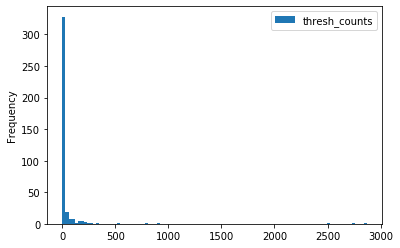

In [103]:
df_counts.plot.hist(bins=100)

In [100]:
df_scores

threshold       auc                                               plot  \
0       2.30.30  0.590753  {0.0: 0.009698275862068968, 0.01: 0.0200222469...   
1       2.30.30  0.586261  {0.0: 0.0, 0.01: 0.007007786429365971, 0.02: 0...   
2       2.30.30  0.589774  {0.0: 0.015618661257606484, 0.01: 0.0478448275...   
3       2.30.30  0.614944  {0.0: 0.011285266457680247, 0.01: 0.0237422272...   
4       2.30.30  0.592892  {0.0: 0.008836206896551728, 0.01: 0.0393939393...   
...         ...       ...                                                ...   
18224       4_c  0.407629  {0.0: 0.012541620421753606, 0.01: 0.0269956458...   
18225       4_c  0.431029  {0.0: 0.0, 0.01: 0.002641509433962264, 0.02: 0...   
18226       4_c  0.441042  {0.0: 0.0058429701765063905, 0.01: 0.007987421...   
18227       4_c  0.465673  {0.0: 0.0, 0.01: 0.004990870359099208, 0.02: 0...   
18228       4_c  0.491226  {0.0: 0.005306603773584905, 0.01: 0.0232220609...   

                                                pr_curve  true_pos  true_neg  \
0      {0.0: 0.0, 0.01: 0.08249085792886908, 0.02: 0....       145      6041   
1      {0.0: 0.0, 0.01: 0.018393020416125942, 0.02: 0...       145      6041   
2      {0.01: 0.23735649271363557, 0.02: 0.1344888114...       145      6041   
3      {0.0: 0.0, 0.01: 0.11181338978359098, 0.02: 0....       145      6041   
4      {0.01: 0.1281896356250677, 0.02: 0.07030295573...       145      6041   
...                                                  ...       ...       ...   
18224  {0.0: 1.0, 0.01: 0.3663097704261954, 0.02: 0.1...       265      5921   
18225  {0.0: 0.007717805476293487, 0.01: 0.0158909846...       265      5921   
18226  {0.0: 0.033482142857142856, 0.01: 0.0487479496...       265      5921   
18227  {0.0: 0.002069086701914662, 0.01: 0.0342122708...       265      5921   
18228  {0.0: 0.017355371900826446, 0.01: 0.0939751140...       265      5921   

      prot_name  exp_median  exp_mean   exp_var  thresh_count  
0        O94885    0.596486  0.540525  0.044557           146  
1        Q02779    0.630525  0.583207  0.058794           146  
2        P14317    0.607859  0.543529  0.064817           146  
3        Q13882    0.491689  0.450026  0.047029           146  
4        O00160    0.512043  0.487436  0.059632           146  
...         ...         ...       ...       ...           ...  
18224    P51991    0.768229  0.696402  0.071436           266  
18225    Q9BRJ9    0.325184  0.331819  0.038582           266  
18226    O60682    0.359253  0.349586  0.042315           266  
18227    P23352    0.391664  0.370647  0.033245           266  
18228    P98164    0.091782  0.106332  0.005767           266  

[18229 rows x 11 columns]

In [104]:
df_scores = df_scores[df_scores['thresh_count']>=100]

In [105]:
df_scores

threshold       auc                                               plot  \
0       2.30.30  0.590753  {0.0: 0.009698275862068968, 0.01: 0.0200222469...   
1       2.30.30  0.586261  {0.0: 0.0, 0.01: 0.007007786429365971, 0.02: 0...   
2       2.30.30  0.589774  {0.0: 0.015618661257606484, 0.01: 0.0478448275...   
3       2.30.30  0.614944  {0.0: 0.011285266457680247, 0.01: 0.0237422272...   
4       2.30.30  0.592892  {0.0: 0.008836206896551728, 0.01: 0.0393939393...   
...         ...       ...                                                ...   
18224       4_c  0.407629  {0.0: 0.012541620421753606, 0.01: 0.0269956458...   
18225       4_c  0.431029  {0.0: 0.0, 0.01: 0.002641509433962264, 0.02: 0...   
18226       4_c  0.441042  {0.0: 0.0058429701765063905, 0.01: 0.007987421...   
18227       4_c  0.465673  {0.0: 0.0, 0.01: 0.004990870359099208, 0.02: 0...   
18228       4_c  0.491226  {0.0: 0.005306603773584905, 0.01: 0.0232220609...   

                                                pr_curve  true_pos  true_neg  \
0      {0.0: 0.0, 0.01: 0.08249085792886908, 0.02: 0....       145      6041   
1      {0.0: 0.0, 0.01: 0.018393020416125942, 0.02: 0...       145      6041   
2      {0.01: 0.23735649271363557, 0.02: 0.1344888114...       145      6041   
3      {0.0: 0.0, 0.01: 0.11181338978359098, 0.02: 0....       145      6041   
4      {0.01: 0.1281896356250677, 0.02: 0.07030295573...       145      6041   
...                                                  ...       ...       ...   
18224  {0.0: 1.0, 0.01: 0.3663097704261954, 0.02: 0.1...       265      5921   
18225  {0.0: 0.007717805476293487, 0.01: 0.0158909846...       265      5921   
18226  {0.0: 0.033482142857142856, 0.01: 0.0487479496...       265      5921   
18227  {0.0: 0.002069086701914662, 0.01: 0.0342122708...       265      5921   
18228  {0.0: 0.017355371900826446, 0.01: 0.0939751140...       265      5921   

      prot_name  exp_median  exp_mean   exp_var  thresh_count  
0        O94885    0.596486  0.540525  0.044557           146  
1        Q02779    0.630525  0.583207  0.058794           146  
2        P14317    0.607859  0.543529  0.064817           146  
3        Q13882    0.491689  0.450026  0.047029           146  
4        O00160    0.512043  0.487436  0.059632           146  
...         ...         ...       ...       ...           ...  
18224    P51991    0.768229  0.696402  0.071436           266  
18225    Q9BRJ9    0.325184  0.331819  0.038582           266  
18226    O60682    0.359253  0.349586  0.042315           266  
18227    P23352    0.391664  0.370647  0.033245           266  
18228    P98164    0.091782  0.106332  0.005767           266  

[14111 rows x 11 columns]

In [925]:
auc_domid_8 = auc_domid[auc_domid['auc']>=0.8]
auc_domid_2 = auc_domid[auc_domid['auc']<=0.2]

In [927]:
prot = long_form_dom_2[long_form_dom_2['col_1']=='Q8WUP2']
prot = prot[prot["tm_score"] >= 0.0]

In [897]:
prot['no_of_pairs'] = [len(x) for x in prot['dom_pair_scores']]

In [928]:
prot = prot[prot['col_1'] != prot['col_2']]
prot[(prot["tm_score"] >= 0.99) & (prot["exp"] >= 0.99) ]

Empty DataFrame
Columns: [col_1, col_2, exp, pdb_chain_domain_x, pdb_chain_domain_y, dom_pairs, dom_pair_scores, tm_score]
Index: []

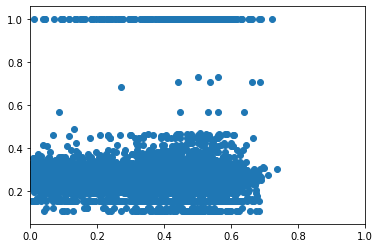

In [929]:
fig, axes = plt.subplots()
axes.scatter(prot['exp'] , prot['tm_score'])
axes.set_xlim([0.0,1])
plt.show()

In [934]:
auc_domid[auc_domid['prot_name']=='Q6JVE6']


threshold       auc                                               plot  \
26        0.5  0.910372  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   

                                  pr_curve  true_pos  true_neg prot_name  \
26  {0.0: 0.0, 1.0: 0.0004339425739670042}       1.0      6103    Q6JVE6   

    exp_median  exp_mean   exp_var pdb_chain_domain  
26    0.099976  0.124597  0.009468        [1xkiA00]

In [658]:
#auc_domid.sort_values(by=['auc'], ascending=False).head(20)
s = auc_domid.apply(lambda x: pd.Series(x['pdb_chain_domain']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'domain'


In [659]:
auc_ind_domid = auc_domid.drop('pdb_chain_domain', axis=1).join(s)

In [660]:
auc_domid_cath = pd.merge(left=auc_ind_domid, right=data, how='left', left_on='domain', right_on='pdb_chain_domain')

In [905]:
auc_ind_domid

threshold       auc                                           pr_curve  \
0           0.9  0.490087             {0.0: 0.0, 1.0: 0.0002251336695030285}   
1           0.9  0.376558  {0.0: 0.0, 0.05: 0.0009549619441794818, 0.09: ...   
2           0.9  0.263149            {0.0: 0.0, 1.0: 0.00019010859759952808}   
3           0.9  0.544436  {0.0: 0.0, 0.01: 0.007943449567068337, 0.02: 0...   
3           0.9  0.544436  {0.0: 0.0, 0.01: 0.007943449567068337, 0.02: 0...   
...         ...       ...                                                ...   
5560        0.9  0.805900  {0.0: 0.0, 0.14: 0.0028135445251216604, 0.29: ...   
5560        0.9  0.805900  {0.0: 0.0, 0.14: 0.0028135445251216604, 0.29: ...   
5561        0.9  0.502846  {0.0: 0.019685052194635774, 0.01: 0.0689096546...   
5562        0.9  0.512889  {0.0: 0.0559389972005364, 0.01: 0.115025195032...   
5562        0.9  0.512889  {0.0: 0.0559389972005364, 0.01: 0.115025195032...   

      true_pos  true_neg prot_name  exp_median  exp_mean  exp_var       0.0  \
0            1      6103    P15018         0.3  0.290197     0.03  0.000000   
1           22      6082    Q9BUD6         0.6  0.530279     0.05  0.000000   
2            1      6103    Q16619         0.4  0.425880     0.04  0.000000   
3          102      6002    Q9H1Q7         0.7  0.643078     0.06  0.000000   
3          102      6002    Q9H1Q7         0.7  0.643078     0.06  0.000000   
...        ...       ...       ...         ...       ...      ...       ...   
5560         7      6097    Q9H5I1         0.7  0.636992     0.08  0.000000   
5560         7      6097    Q9H5I1         0.7  0.636992     0.08  0.000000   
5561       888      5216    Q8WY91         0.8  0.685806     0.07  0.000000   
5562       889      5215    Q9HBR0         0.7  0.654573     0.07  0.000931   
5562       889      5215    Q9HBR0         0.7  0.654573     0.07  0.000931   

      ...      0.92      0.93      0.94      0.95      0.96      0.97  \
0     ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     ...  0.954545  0.954545  0.954545  0.954545  0.976540  1.000000   
2     ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3     ...  0.950980  0.950980  0.956445  0.972170  0.983607  0.990196   
3     ...  0.950980  0.950980  0.956445  0.972170  0.983607  0.990196   
...   ...       ...       ...       ...       ...       ...       ...   
5560  ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5560  ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5561  ...  0.946373  0.953205  0.962821  0.972499  0.980265  0.988567   
5562  ...  0.927311  0.937204  0.945212  0.955849  0.968416  0.979638   
5562  ...  0.927311  0.937204  0.945212  0.955849  0.968416  0.979638   

          0.98      0.99       1.0   domain  
0     1.000000  1.000000  1.000000  1lkiA00  
1     1.000000  1.000000  1.000000  1lslA01  
2     1.000000  1.000000  1.000000  1lkiA00  
3     0.990196  0.995661  1.000000  1es9A00  
3     0.990196  0.995661  1.000000  1jhnA02  
...        ...       ...       ...      ...  
5560  1.000000  1.000000  1.000000  1q3lA00  
5560  1.000000  1.000000  1.000000  2f69A02  
5561  0.994008  0.997392  1.000000  1s58A00  
5562  0.988639  0.997537  0.999116  1v54A00  
5562  0.988639  0.997537  0.999116  1s58A00  

[11506 rows x 111 columns]

In [661]:
g = auc_ind_domid.groupby(['domain']).agg({'auc': ['mean', 'count']})

In [662]:
g_cath = pd.merge(left=g, right=data, how='left', left_on='domain', right_on='pdb_chain_domain')

/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [663]:
g_cath

(auc, mean)  (auc, count) pdb_chain_domain version           cath  \
0        0.961330             1          1a0rP02  v4_2_0    1.10.168.10   
1        0.523859             1          1a1hA01  v4_2_0    3.30.160.60   
2        0.754913             2          1a1wA00  v4_2_0    1.10.533.10   
3        0.524358             2          1a3qA01  v4_2_0    2.60.40.340   
4        0.589382             1          1a4iA02  v4_2_0  3.40.50.10860   
...           ...           ...              ...     ...            ...   
2298     0.646551             1          3ygsP00  v4_2_0    1.10.533.10   
2299     0.573285            11          4dpvZ00  v4_2_0    2.170.30.10   
2300     0.523746            25          4mt2A00  v4_2_0     4.10.10.10   
2301     0.548509             1          6ldhA01  v4_2_0    3.40.50.720   
2302     0.474161             3          6ldhA02  v4_2_0    3.90.110.10   

       residues  
0       14-96:P  
1     103-132:A  
2        1-83:A  
3      37-221:A  
4      31-119:A  
...         ...  
2298     1-97:P  
2299   22-584:Z  
2300     1-61:A  
2301    1-162:A  
2302  163-329:A  

[2303 rows x 6 columns]

In [292]:
g_cath.sort_values(by=[('auc', 'mean')], ascending=False)

(auc, mean)  (auc, count) pdb_chain_domain version          cath  \
418      1.000000             2          1gqvA00  v4_2_0   3.10.130.10   
2130     0.998771             2          2z7fI00  v4_2_0    4.10.75.10   
1929     0.998198             2          2nyzE00  v4_2_0    2.40.50.40   
876      0.996641             2          1n9rB00  v4_2_0   2.30.30.100   
571      0.995658             2          1j1dE00  v4_2_0    1.20.5.350   
...           ...           ...              ...     ...           ...   
1115     0.076192             2          1qsmD00  v4_2_0   3.40.630.30   
435      0.074062             2          1gxyA00  v4_2_0   3.90.176.10   
1595     0.058660             2          1zndA00  v4_2_0   2.40.128.20   
2020     0.039898             2          2ql2C00  v4_2_0   4.10.280.10   
2159     0.008684             2          3b9wA00  v4_2_0  1.10.3430.10   

       residues  
418     0-134:A  
2130   58-107:I  
1929     7-72:E  
876     18-86:B  
571   200-274:E  
...         ...  
1115    5-156:D  
435     4-226:A  
1595    1-157:A  
2020  543-602:C  
2159    8-369:A  

[2303 rows x 6 columns]

In [ ]:
df_scores = df_scores[df_scores['threshold']==0.9]
df_score

In [77]:
df_scores['exp_median'] = df_scores['exp_median'].round(1)

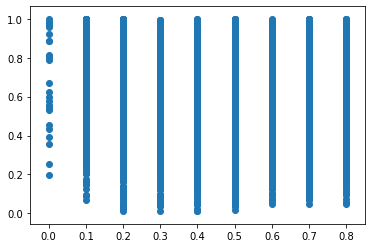

In [814]:
fig, axes = plt.subplots()
axes.scatter(df_scores['exp_median'] , df_scores['auc'] )
#axes.set_ylim([0,1])
plt.show()

In [77]:
df_scores['exp_var'] = df_scores['exp_var'].round(2)

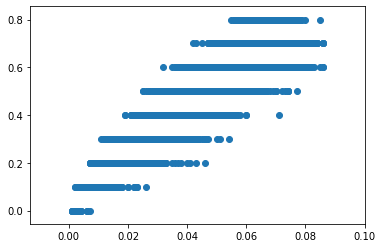

In [462]:
fig, axes = plt.subplots()
axes.scatter(df_scores['exp_var'] , df_scores['exp_median'] )
#axes.set_ylim([0,1])
plt.show()

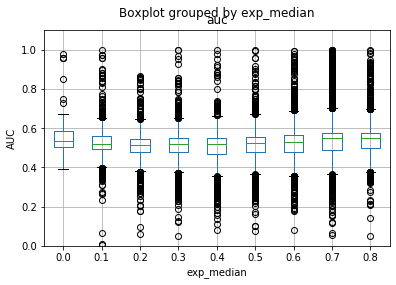

In [81]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='exp_median', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [83]:
df_scores['threshold'].value_counts()


3_c          2870
2_c          2747
1_c          2506
2.170.30      898
3.40.50       779
             ... 
2.115.10        2
2.60.90         2
1.10.1370       2
2.30.39         2
3.40.1180       2
Name: threshold, Length: 385, dtype: int64

In [76]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='exp_mean', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/lohia/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-76-8034b242cf56>", line 5, in <module>
    bp = df_scores.boxplot(column=['auc'], by='exp_mean', ax=axes)
  File "/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py", line 505, in boxplot_frame
    **kwargs,
  File "/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py", line 391, in boxplot_frame
    **kwds,
  File "/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py", line 341, in boxplot
    return_type=return_type,
  File "/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py", line 211, in _grouped_plot_by_column
    re_plotf = plotf(keys, values, ax, **kwargs)
  File "/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/plo

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f3ca9315290> (for post_execute):


KeyboardInterrupt: 

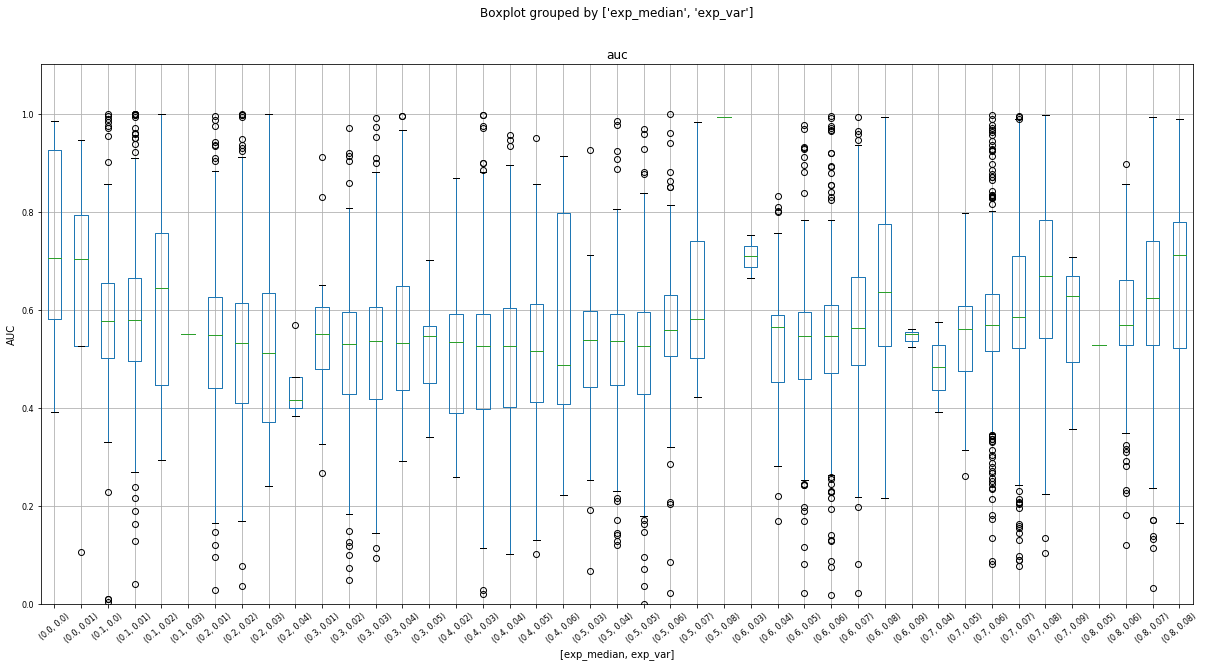

In [503]:
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by=[ 'exp_median', 'exp_var'], ax=axes,  rot=40, fontsize=8)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [74]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name', 'exp_median', 'exp_mean', 'exp_var'])
df_scores.dropna(inplace=True)

In [134]:
df_scores

threshold       auc                                               plot  \
1           0.9  0.507598  {0.0: 0.0037369705034375695, 0.01: 0.010856857...   
2           0.9  0.488071  {0.0: 0.0036653964797677373, 0.01: 0.008974643...   
6           0.9  0.510414  {0.0: 0.003271235307163451, 0.01: 0.0105020727...   
7           0.9  0.491765  {0.0: 0.002477803014660335, 0.01: 0.0089995447...   
9           0.9  0.516295  {0.0: 0.003946392928428856, 0.01: 0.0128954212...   
...         ...       ...                                                ...   
6171        0.9  0.494604  {0.0: 0.0022664348721911014, 0.01: 0.010133578...   
6172        0.9  0.518211  {0.0: 0.004043195659962126, 0.01: 0.0171756487...   
6173        0.9  0.506992  {0.0: 0.002202491568586964, 0.01: 0.0087373639...   
6174        0.9  0.515147  {0.0: 0.002818605213814795, 0.01: 0.0126471694...   
6183        0.9  0.512876  {0.0: 0.005739631847416279, 0.01: 0.0171713715...   

                                               pr_curve  true_pos  true_neg  \
1     {0.0: 0.5512050067191001, 0.01: 0.436813536357...      2505      3681   
2     {0.0: 0.5827610682856249, 0.01: 0.389469781352...      2505      3681   
6     {0.0: 0.3585345975175593, 0.01: 0.428500021335...      2505      3681   
7     {0.0: 0.4467145065138522, 0.01: 0.386346243902...      2505      3681   
9     {0.0: 0.6999477403412919, 0.01: 0.487325772713...      2505      3681   
...                                                 ...       ...       ...   
6171  {0.0: 0.27948896878619706, 0.01: 0.39594536540...      2505      3681   
6172  {0.0: 0.48001151077986787, 0.01: 0.52166289516...      2505      3681   
6173  {0.0: 0.4017373344818623, 0.01: 0.361915538615...      2505      3681   
6174  {0.0: 0.43131032471750236, 0.01: 0.46142020274...      2505      3681   
6183  {0.0: 0.7351175240881122, 0.01: 0.586205950848...      2505      3681   

     prot_name  exp_median  exp_mean   exp_var  
1       P35249    0.682302  0.632451  0.072187  
2       P33260    0.060164  0.070642  0.002702  
6       Q8IXB1    0.762142  0.689405  0.071009  
7       O00155    0.104278  0.134948  0.012678  
9       Q9UHM6    0.097524  0.109065  0.005099  
...        ...         ...       ...       ...  
6171    P53778    0.577621  0.533580  0.051633  
6172    Q8TAS1    0.716909  0.654450  0.076315  
6173    P17483    0.494868  0.446837  0.035636  
6174    Q03052    0.221569  0.228963  0.020184  
6183    Q9H8S9    0.742077  0.656814  0.081120  

[2506 rows x 10 columns]

In [624]:
df_scores[(df_scores['auc'] == 1) & (df_scores['para_dig'] == 1) ]['auc'].value_counts()

1.0    183
Name: auc, dtype: int64

In [717]:
df_scores = df_scores[df_scores['para_dig'] == 1 ]

In [722]:
df_scores = df_scores[df_scores['para_dig'] == 0 ]

In [109]:
df_scores = df_scores[df_scores['exp_median'] > 0.5]

In [110]:
df_scores

threshold       auc                                               plot  \
263         0.9  0.404009  {0.0: 0.003773584905660377, 0.01: 0.0259005145...   
447         0.9  0.414545  {0.0: 0.0007547169811320754, 0.01: 0.009155583...   
458         0.9  0.396480  {0.0: 0.0, 0.01: 0.0054169202678027994, 0.02: ...   
673         0.9  0.417071  {0.0: 0.00012578616352201257, 0.01: 0.00815581...   
701         0.9  0.401949  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.00587...   
821         0.9  0.401307  {0.0: 0.002389937106918239, 0.01: 0.0093411691...   
919         0.9  0.414897  {0.0: 0.0015094339622641509, 0.01: 0.008947048...   
1322        0.9  0.411820  {0.0: 0.006329884357881923, 0.01: 0.0186910377...   
1347        0.9  0.418108  {0.0: 0.0005031446540880503, 0.01: 0.008886183...   
1548        0.9  0.392308  {0.0: 0.00012578616352201257, 0.01: 0.00440251...   
1605        0.9  0.414590  {0.0: 0.004138770541692027, 0.01: 0.0122791254...   
1720        0.9  0.442961  {0.0: 0.009655937846836847, 0.01: 0.0188679245...   
1823        0.9  0.395179  {0.0: 0.0034083992696287277, 0.01: 0.010125786...   
1865        0.9  0.396394  {0.0: 0.0, 0.01: 0.003587998762759047, 0.02: 0...   
1915        0.9  0.415986  {0.0: 0.004138770541692027, 0.01: 0.0111320754...   
2074        0.9  0.416437  {0.0: 0.0, 0.01: 0.0011320754716981133, 0.02: ...   
2162        0.9  0.403046  {0.0: 0.0027672955974842764, 0.01: 0.003773584...   
2204        0.9  0.431140  {0.0: 0.0014607425441265976, 0.01: 0.011069182...   
2425        0.9  0.418997  {0.0: 0.002389937106918239, 0.01: 0.0051572327...   
2566        0.9  0.409174  {0.0: 0.003396226415094339, 0.01: 0.0038993710...   
2918        0.9  0.416034  {0.0: 0.0031649421789409615, 0.01: 0.009774203...   
2931        0.9  0.408115  {0.0: 0.004009433962264151, 0.01: 0.0197808886...   
2960        0.9  0.409560  {0.0: 0.002012578616352201, 0.01: 0.0125989044...   
3057        0.9  0.405029  {0.0: 0.0, 0.01: 0.0046396535725332505, 0.02: ...   
3188        0.9  0.416837  {0.0: 0.0, 0.01: 0.007851491174680461, 0.02: 0...   
3261        0.9  0.429941  {0.0: 0.0, 0.01: 0.009375, 0.02: 0.02072378595...   
3459        0.9  0.413105  {0.0: 0.004952830188679245, 0.01: 0.0130188679...   
3504        0.9  0.402837  {0.0: 0.0032866707242848446, 0.01: 0.011194968...   
3684        0.9  0.422726  {0.0: 0.0, 0.01: 0.004825239715434581, 0.02: 0...   
3878        0.9  0.411851  {0.0: 0.003522012578616352, 0.01: 0.0140330188...   
4064        0.9  0.433303  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0126724866234863...   
4173        0.9  0.403795  {0.0: 0.003144654088050314, 0.01: 0.0058150324...   
4319        0.9  0.401667  {0.0: 0.008018867924528302, 0.01: 0.0141045468...   
4394        0.9  0.412915  {0.0: 0.00037735849056603777, 0.01: 0.01010346...   
4597        0.9  0.410950  {0.0: 0.0018867924528301885, 0.01: 0.009279307...   
4795        0.9  0.402686  {0.0: 0.018029350104821804, 0.01: 0.0280503144...   
4854        0.9  0.409808  {0.0: 0.005599513085818624, 0.01: 0.0075471698...   
4880        0.9  0.424489  {0.0: 0.0015094339622641509, 0.01: 0.003773584...   
4916        0.9  0.421539  {0.0: 0.0016352201257861633, 0.01: 0.012499999...   
5061        0.9  0.407629  {0.0: 0.012541620421753606, 0.01: 0.0269956458...   
5155        0.9  0.420882  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0064858490566037...   
5358        0.9  0.411673  {0.0: 0.005542452830188679, 0.01: 0.0166768107...   
5451        0.9  0.400921  {0.0: 0.012874583795782463, 0.01: 0.0253968253...   
5453        0.9  0.417419  {0.0: 0.0, 0.01: 0.0024126198577172904, 0.02: ...   
5469        0.9  0.405710  {0.0: 0.010432852386237514, 0.01: 0.0258254716...   
5589        0.9  0.407786  {0.0: 0.0006289308176100629, 0.01: 0.004716981...   
5672        0.9  0.409996  {0.0: 0.020964360587002094, 0.01: 0.0288895762...   
5681        0.9  0.407605  {0.0: 0.0036477987421383645, 0.01: 0.004654088...   
5741        0.9  0.419642  {0.0: 0.0030432136335970784, 0.01: 0.012398921...   
5822  

In [667]:
df_scores = df_scores[(df_scores['exp_median'] > 0.3) & (df_scores['exp_median'] < 0.7)]

In [707]:
df_scores = auc_domid_8

In [106]:
df_scores = pd.concat([df_scores.drop(['plot'], axis=1), df_scores['plot'].apply(pd.Series)], axis=1)

In [107]:
df_plot = df_scores.groupby(['threshold']).mean()

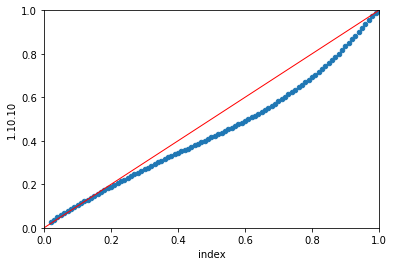

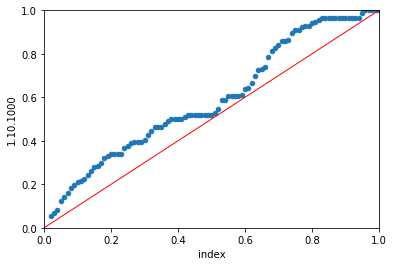

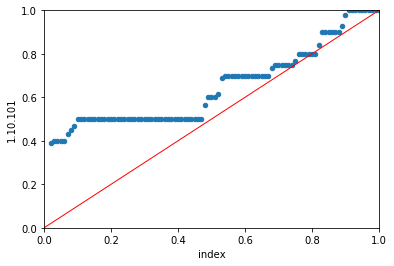

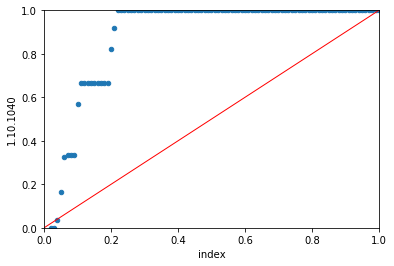

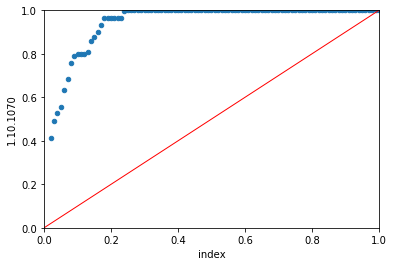

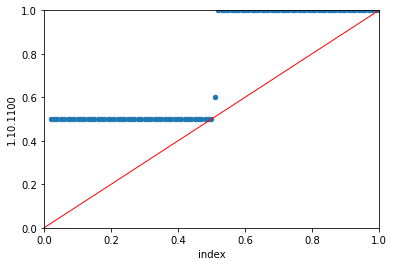

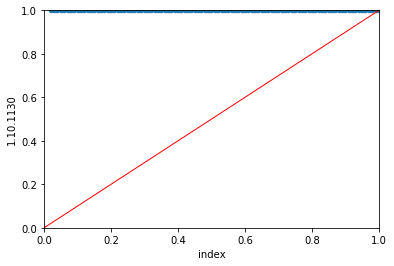

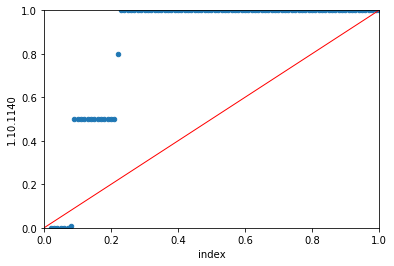

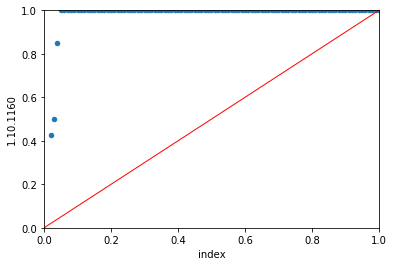

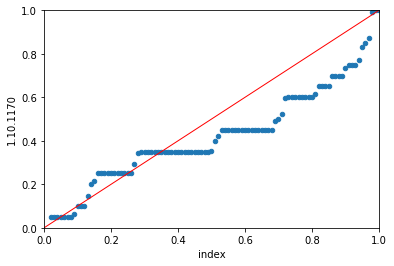

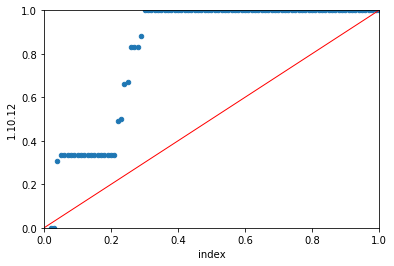

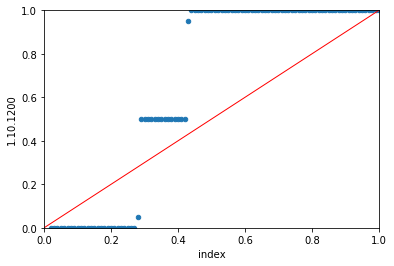

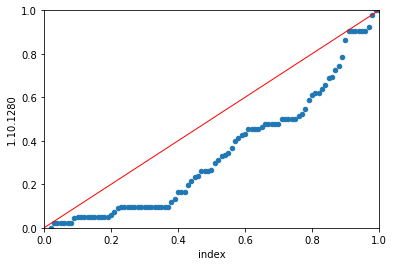

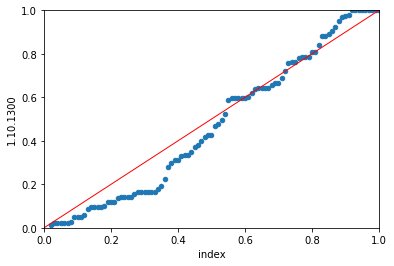

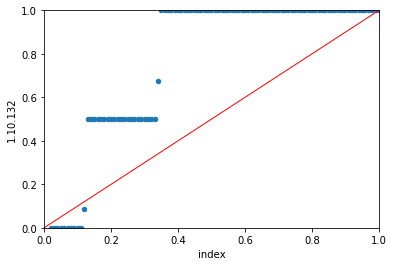

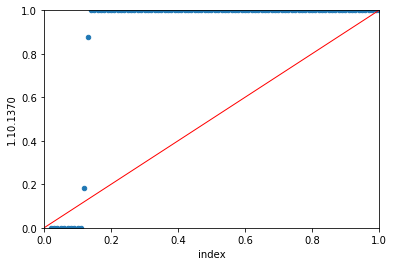

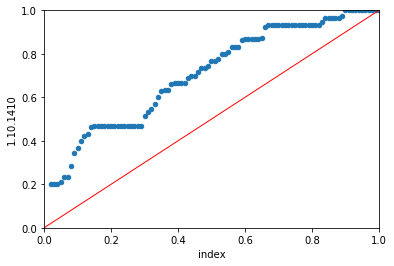

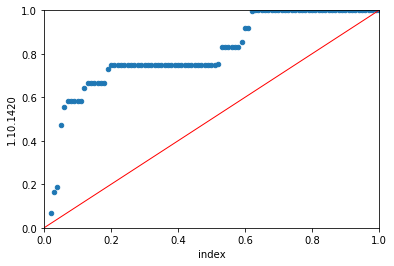

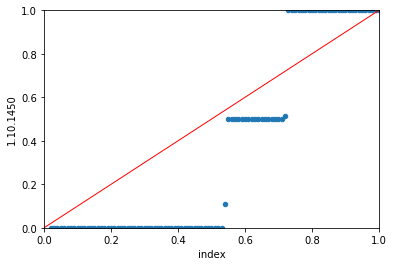

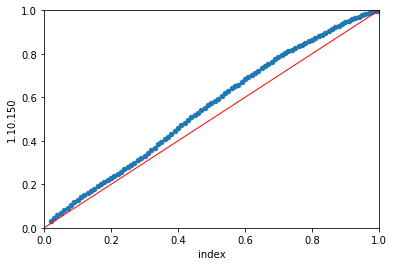

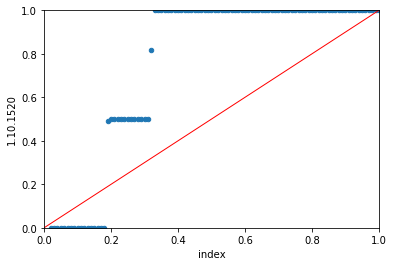

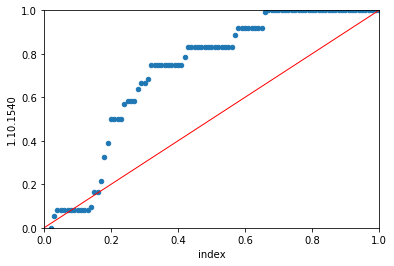

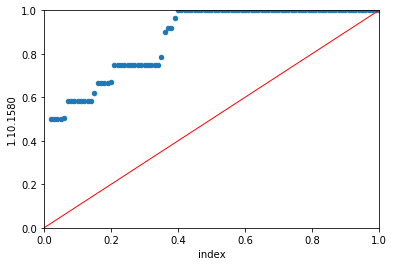

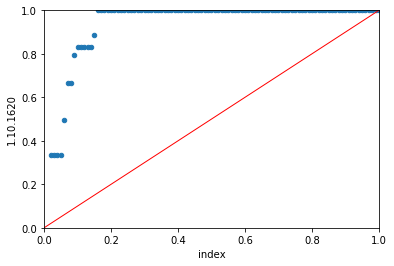

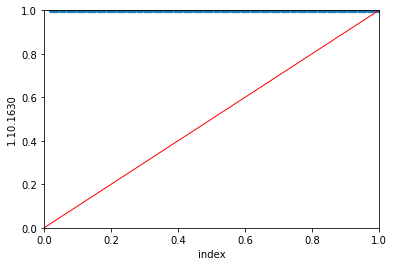

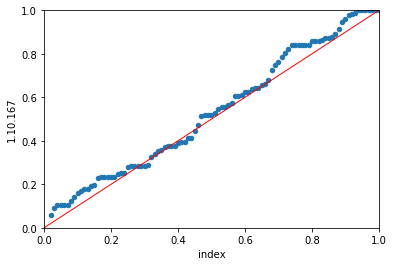

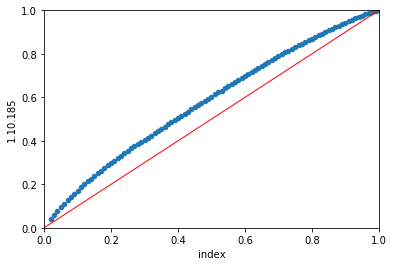

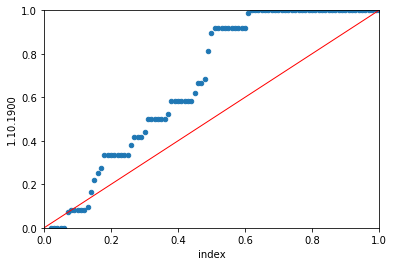

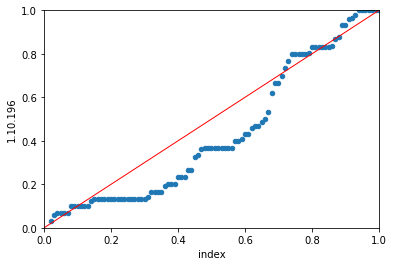

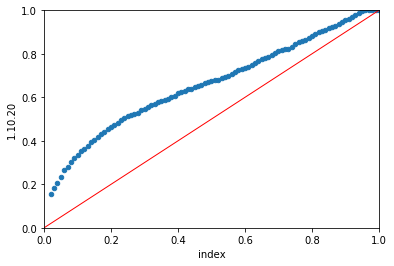

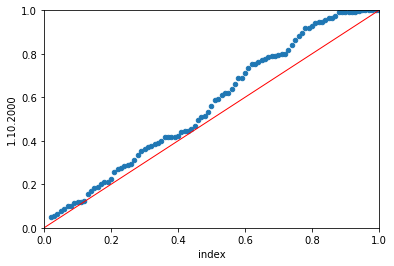

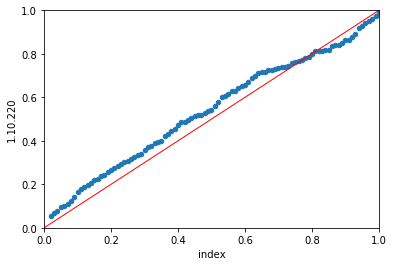

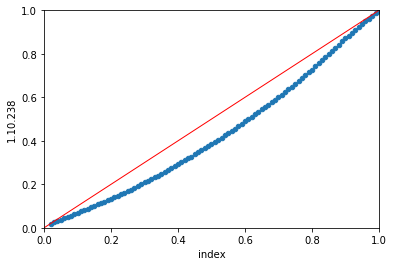

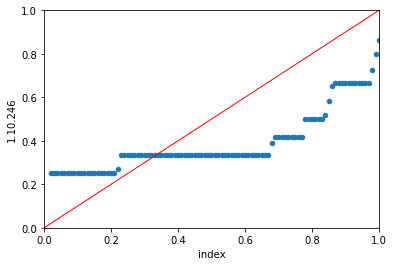

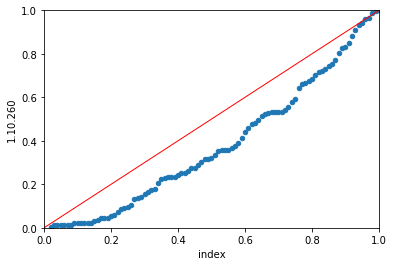

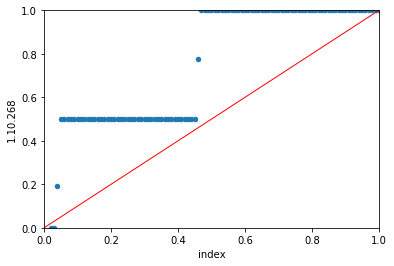

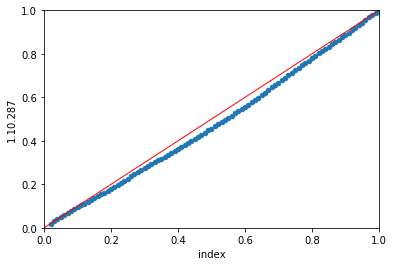

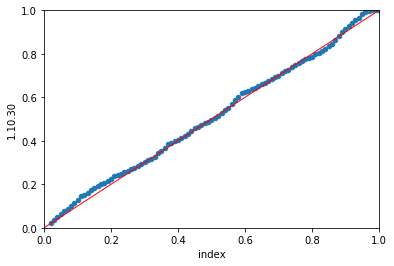

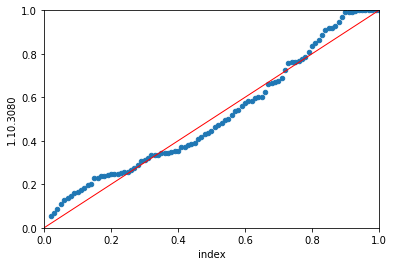

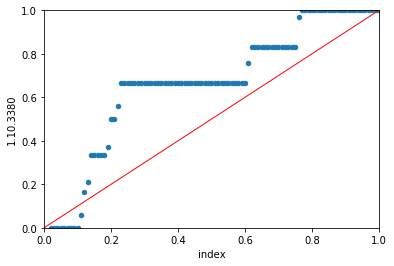

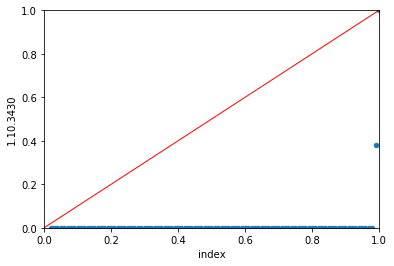

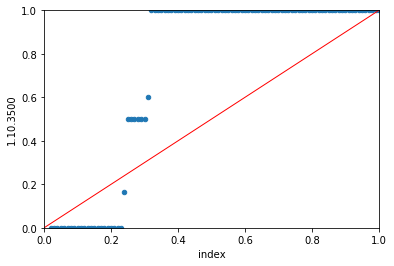

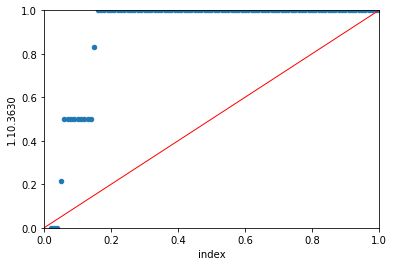

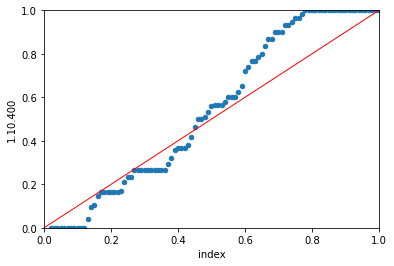

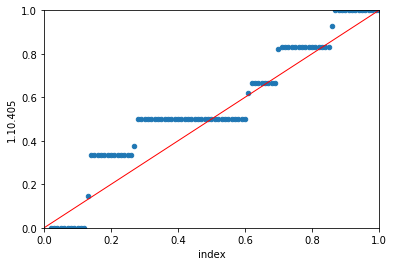

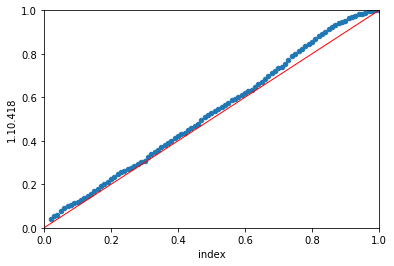

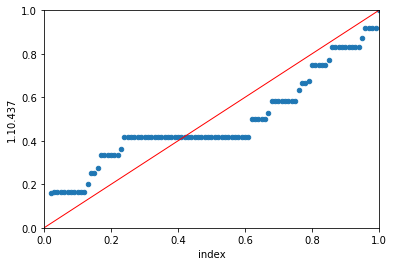

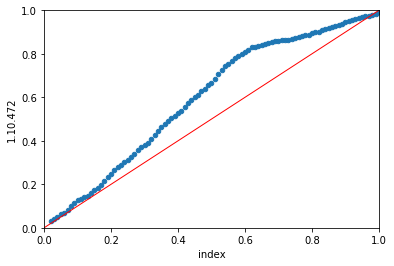

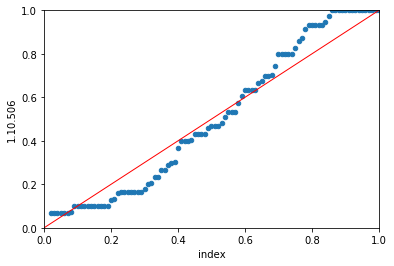

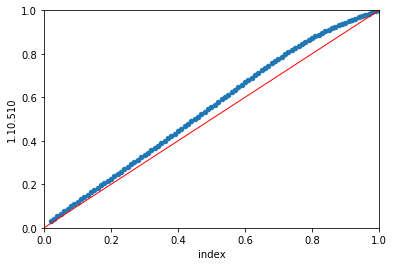

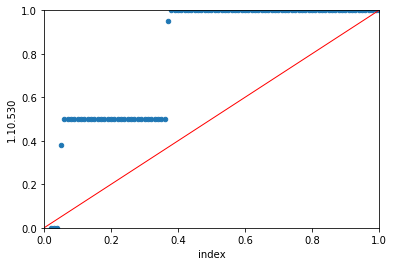

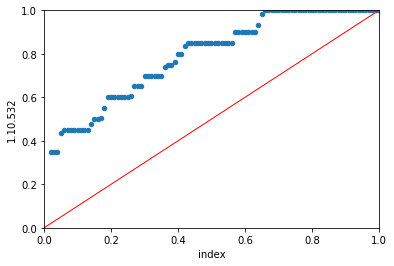

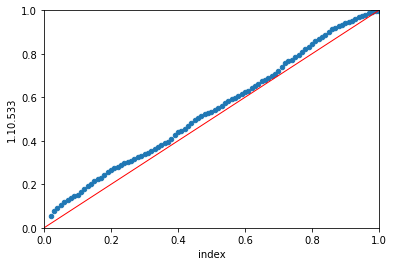

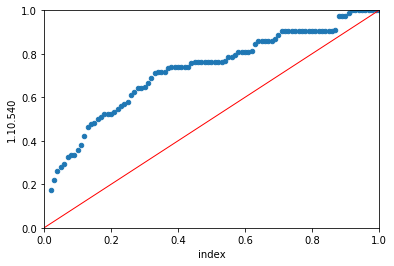

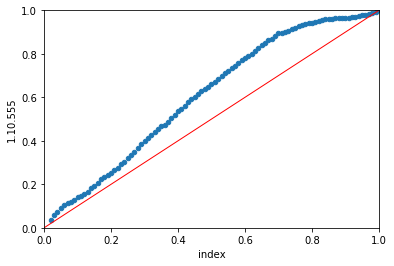

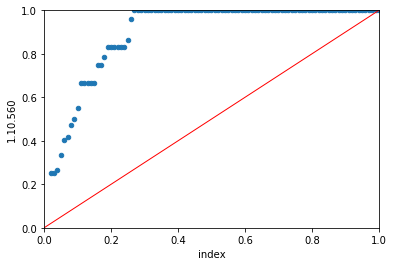

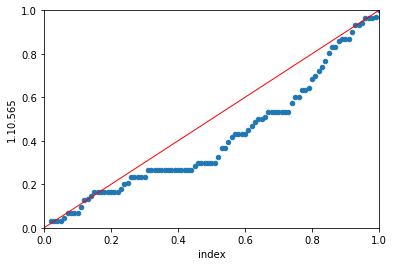

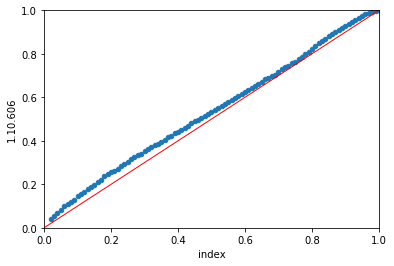

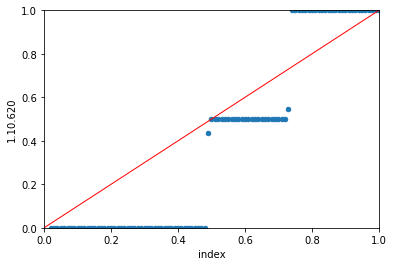

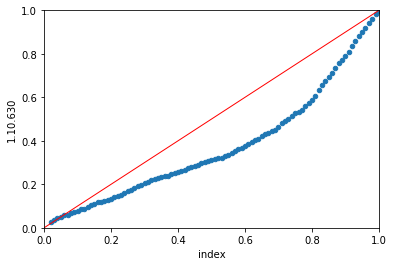

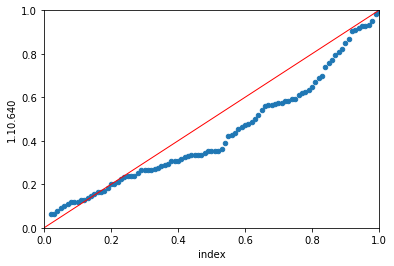

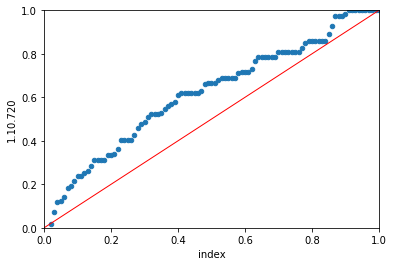

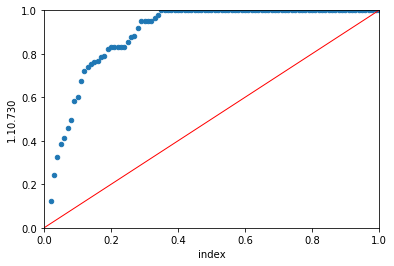

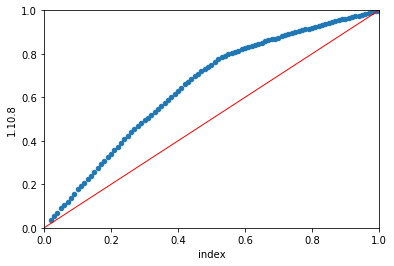

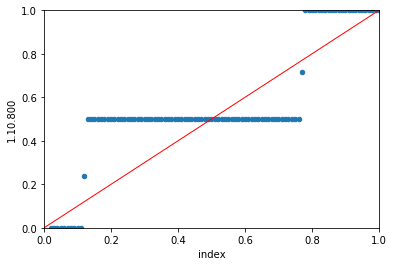

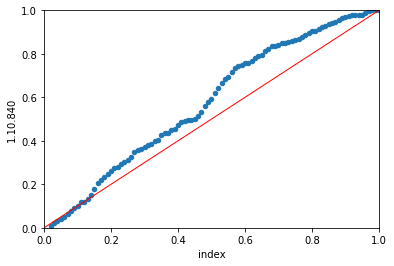

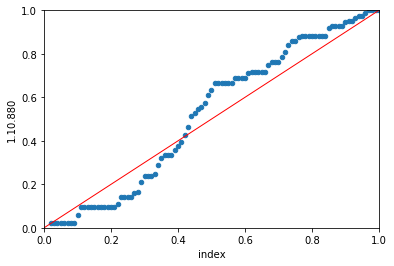

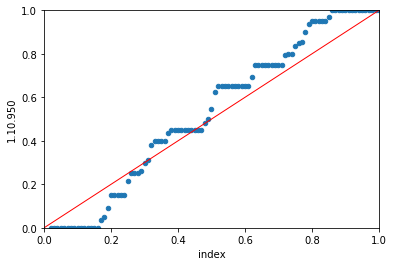

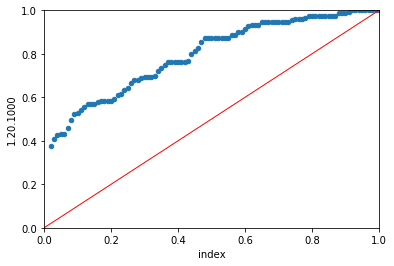

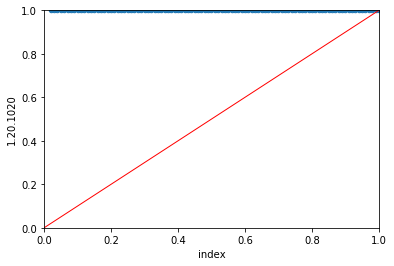

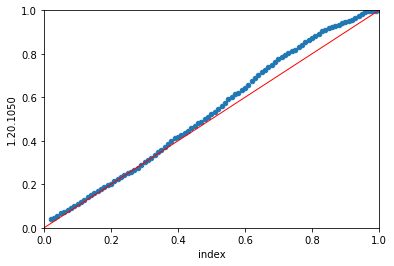

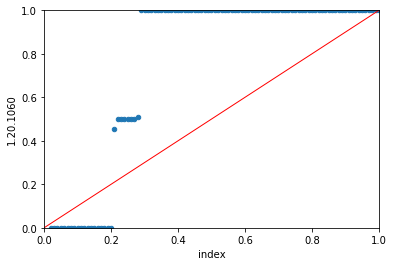

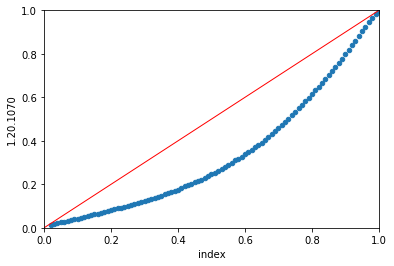

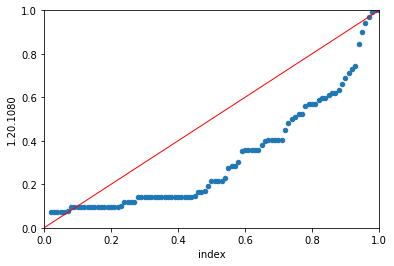

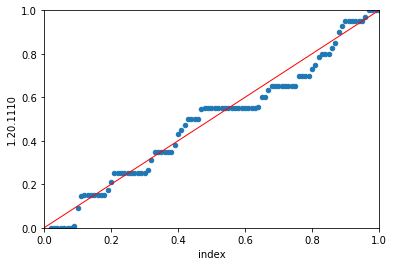

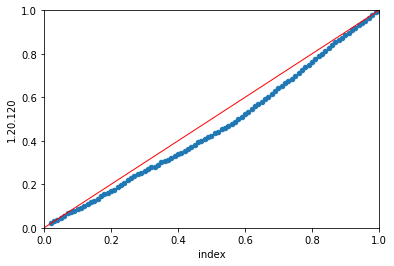

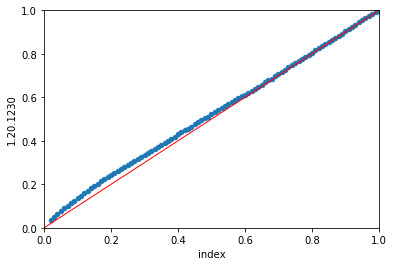

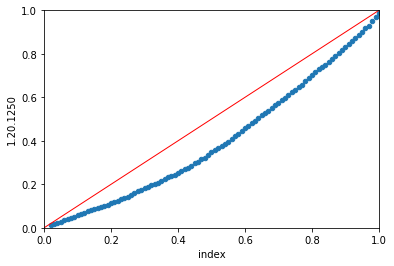

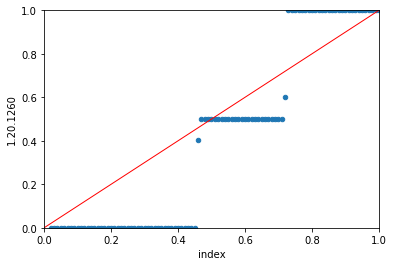

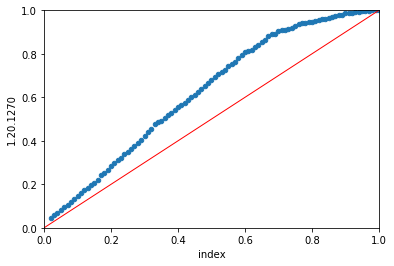

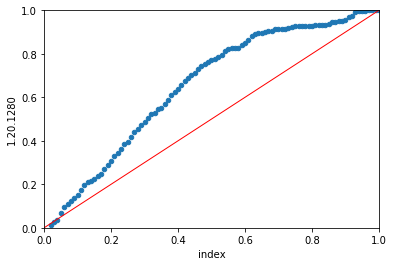

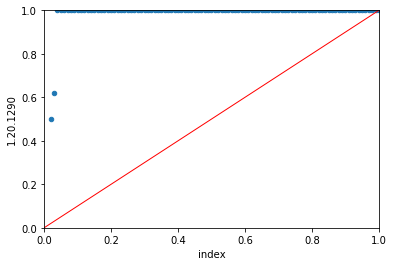

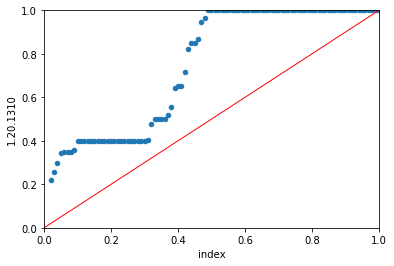

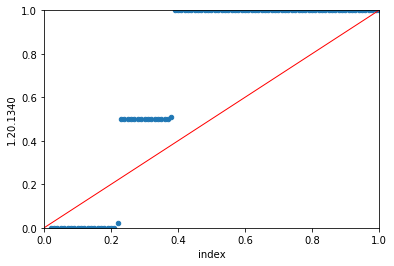

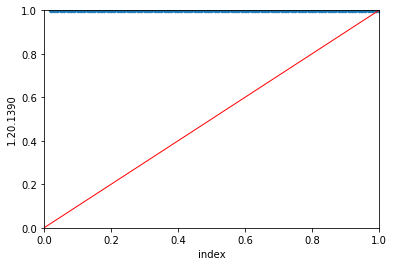

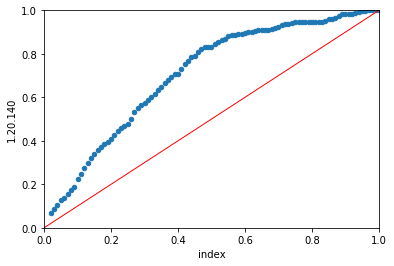

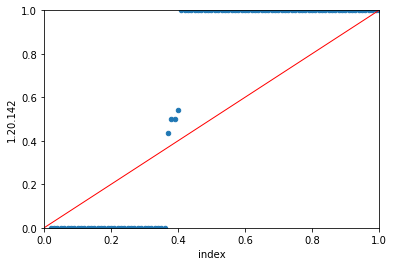

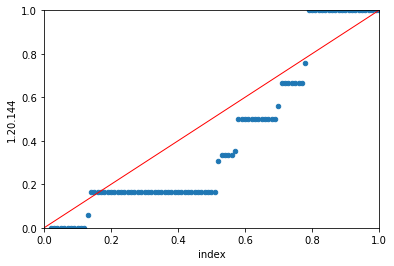

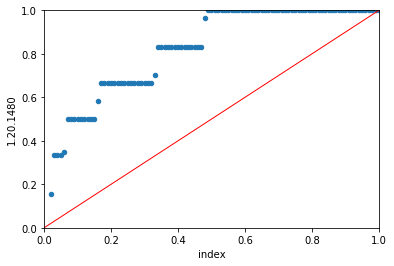

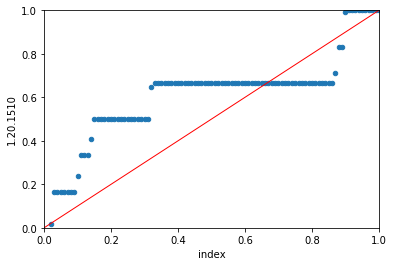

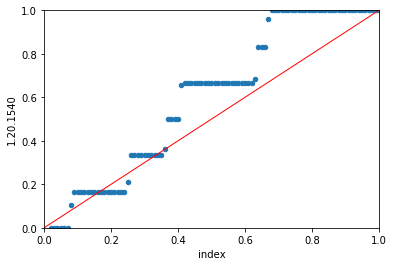

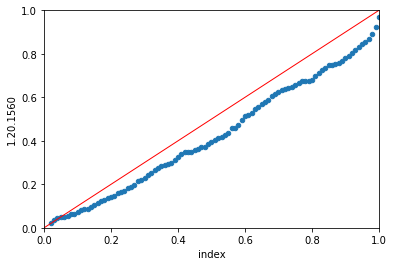

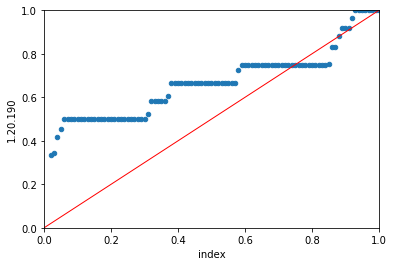

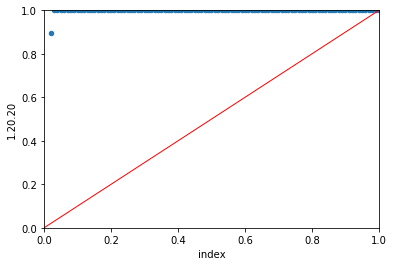

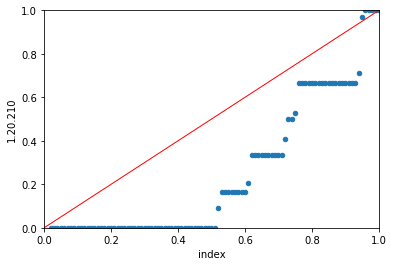

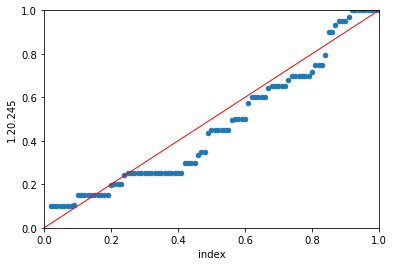

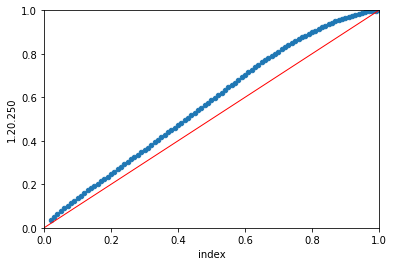

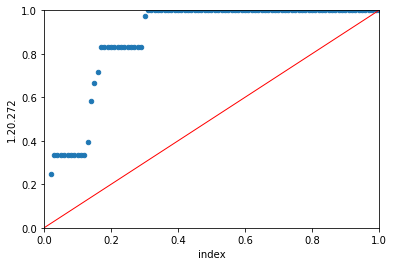

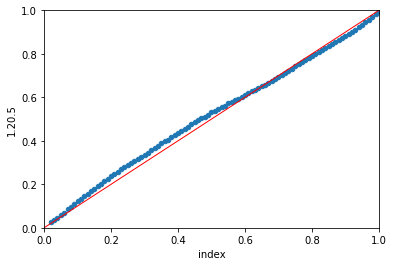

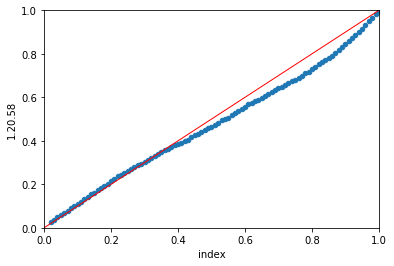

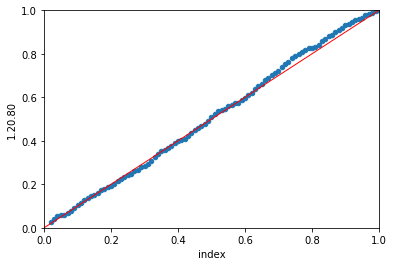

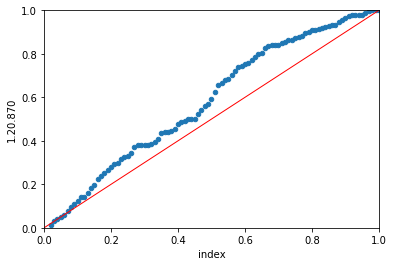

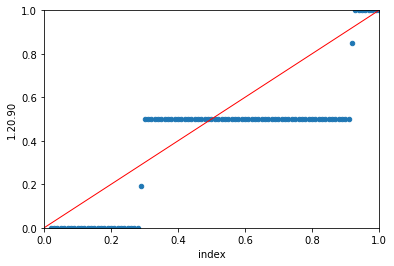

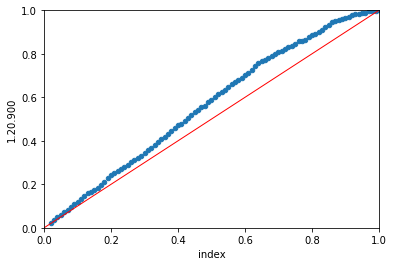

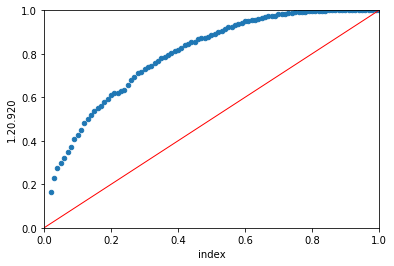

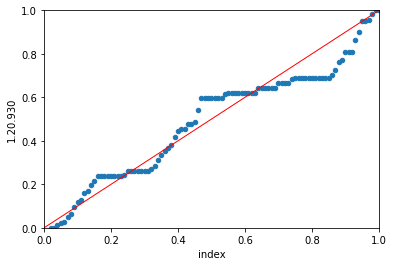

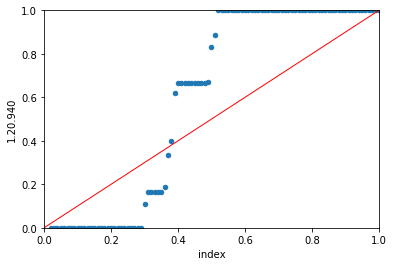

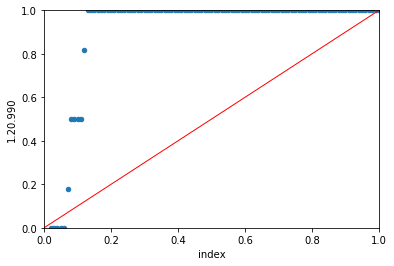

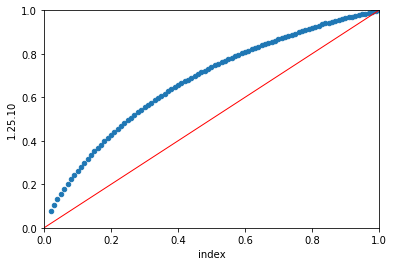

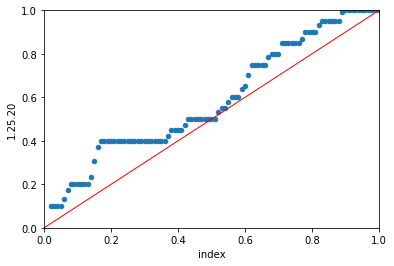

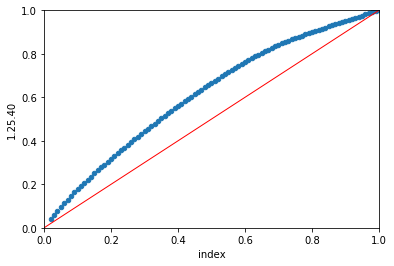

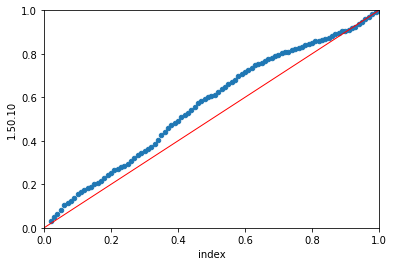

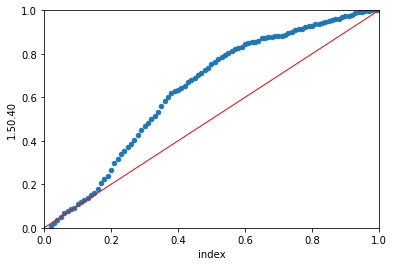

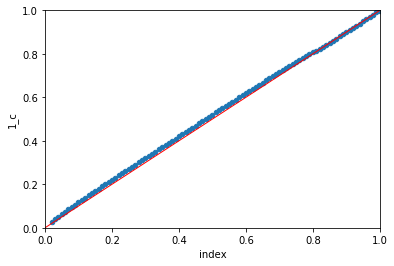

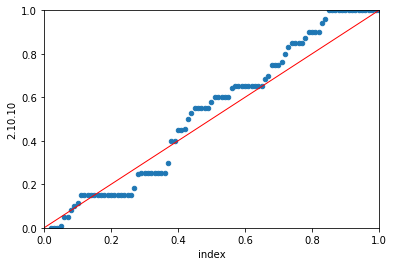

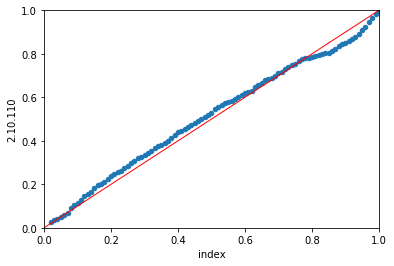

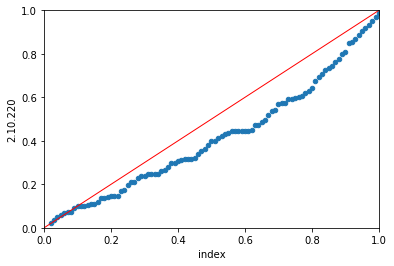

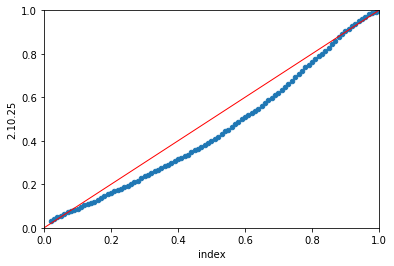

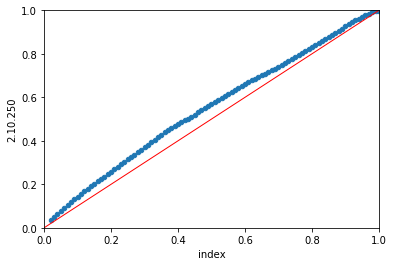

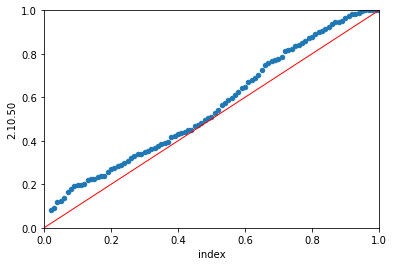

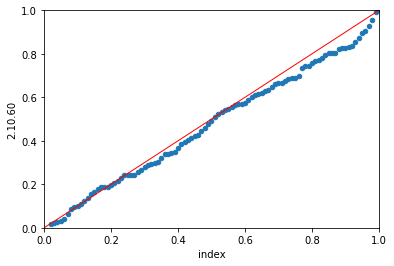

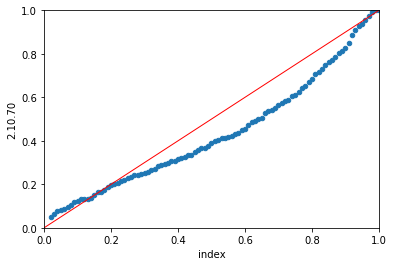

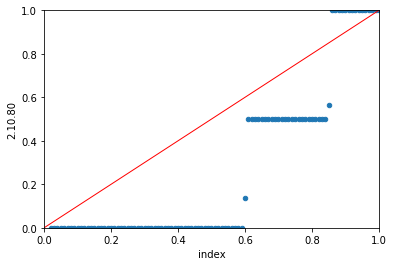

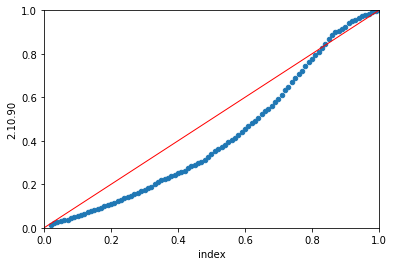

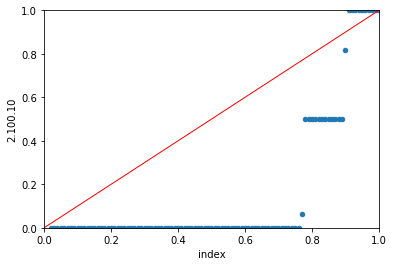

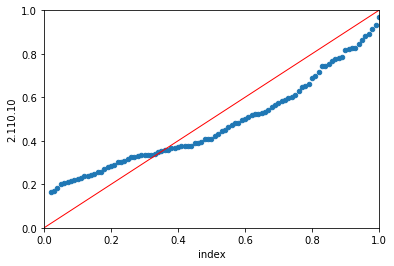

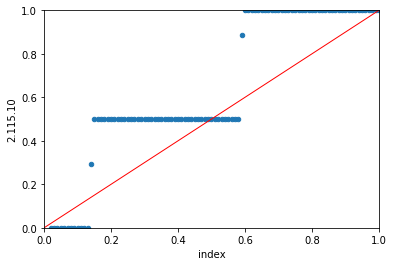

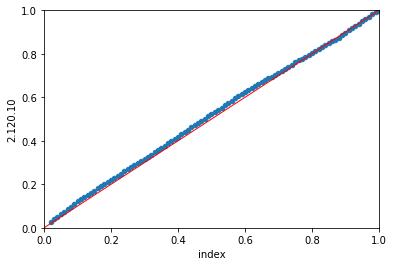

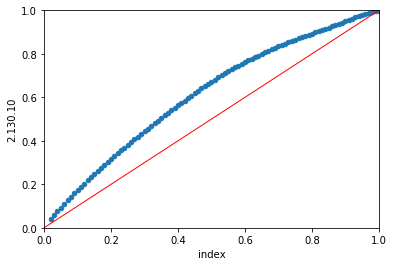

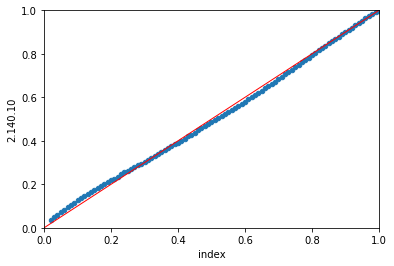

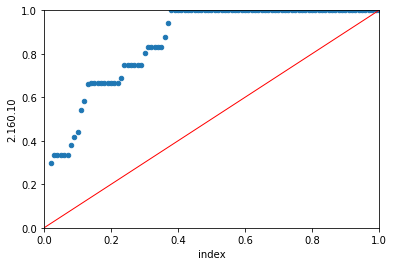

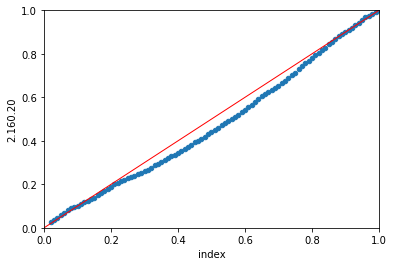

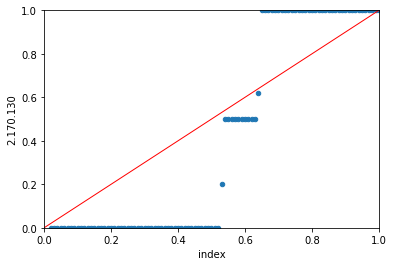

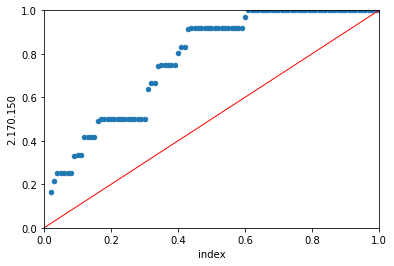

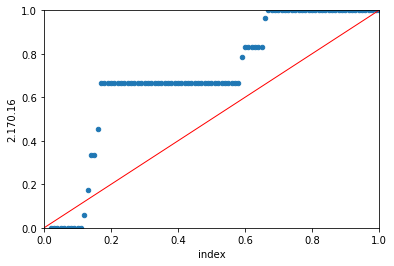

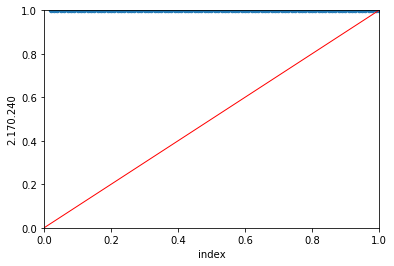

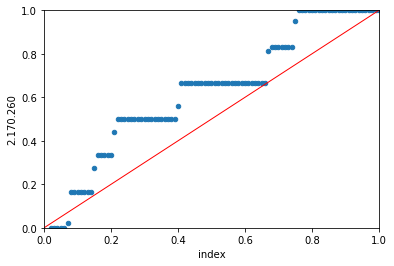

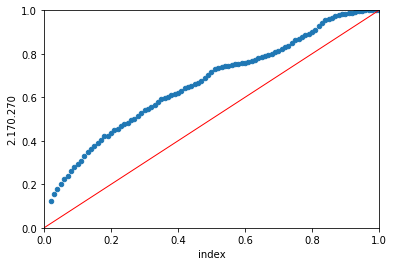

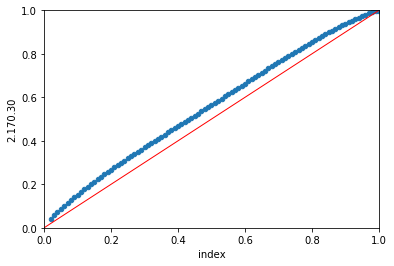

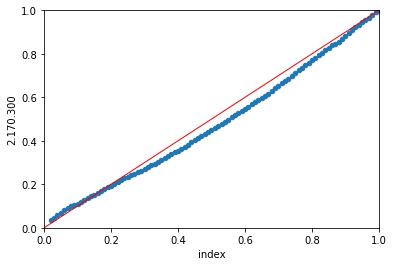

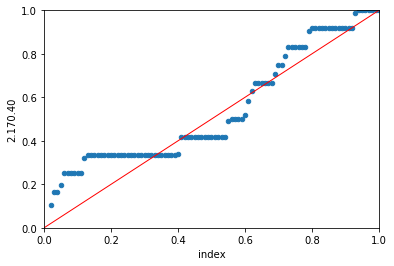

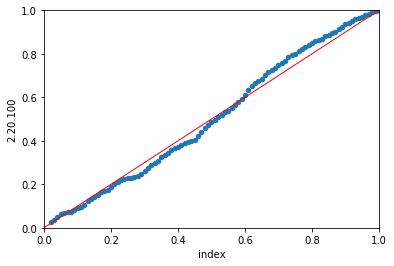

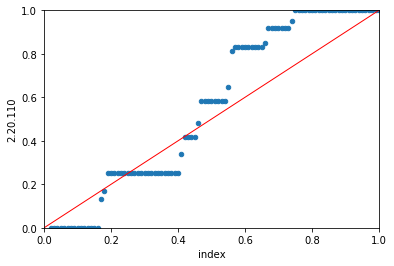

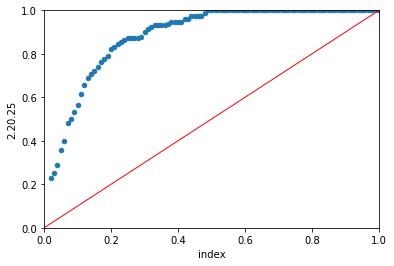

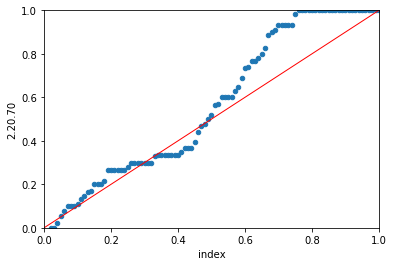

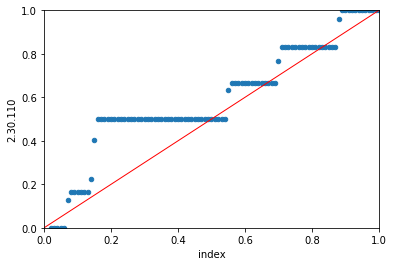

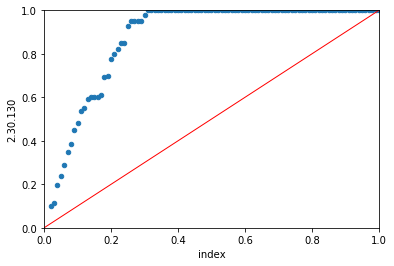

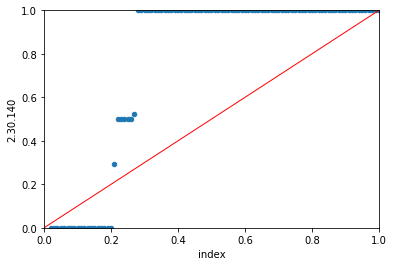

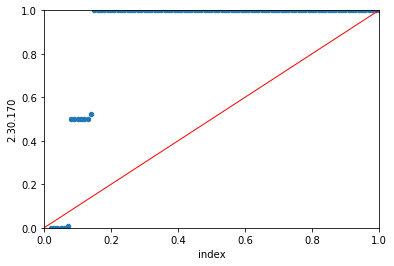

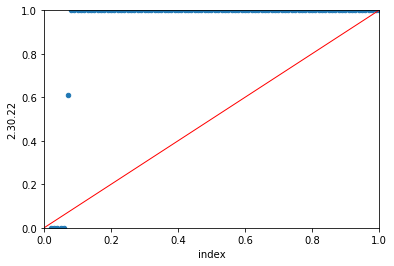

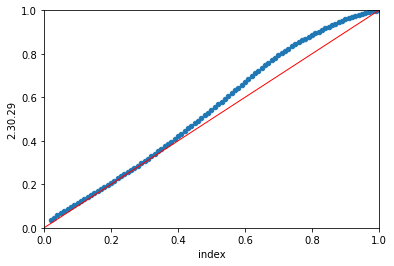

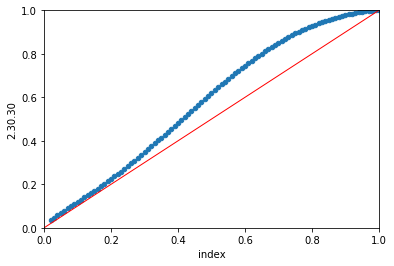

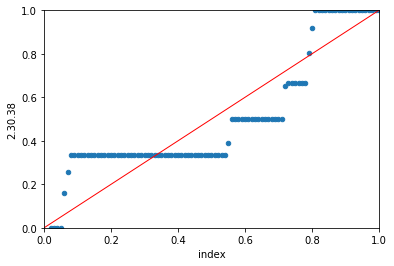

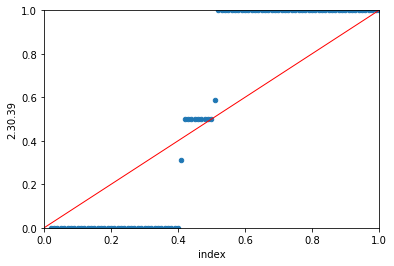

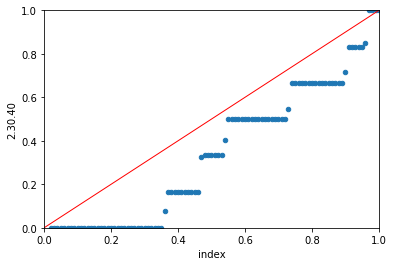

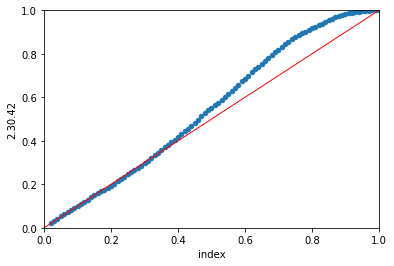

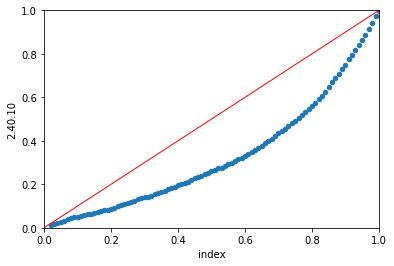

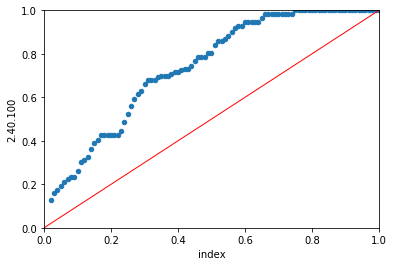

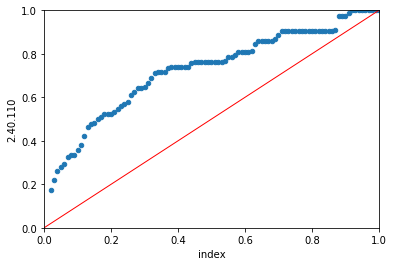

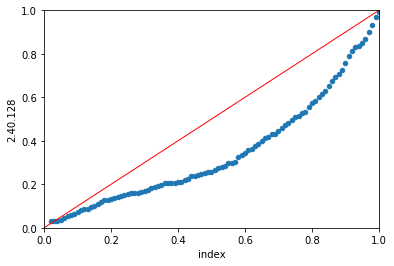

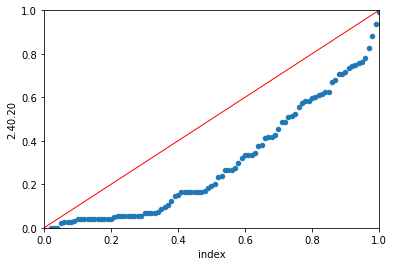

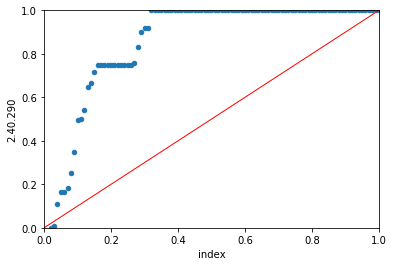

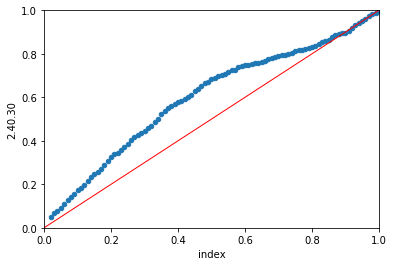

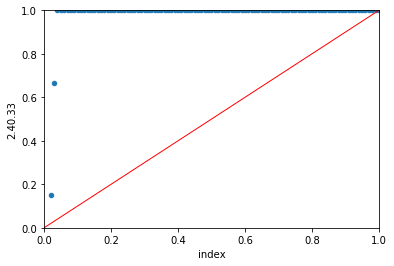

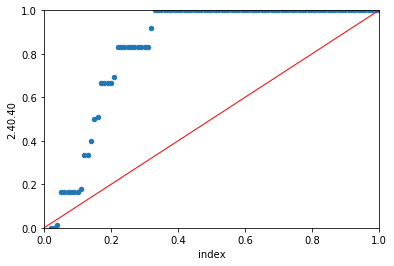

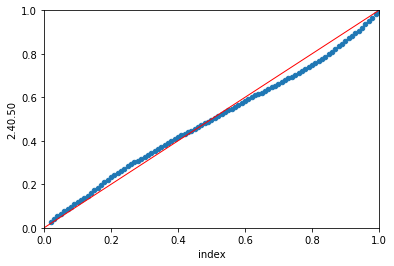

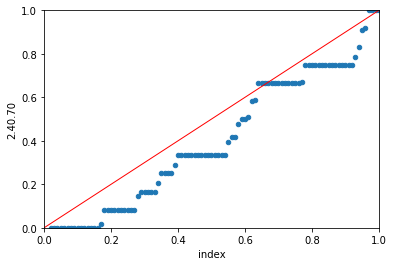

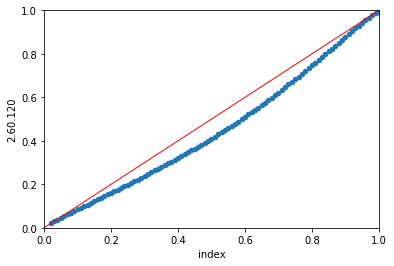

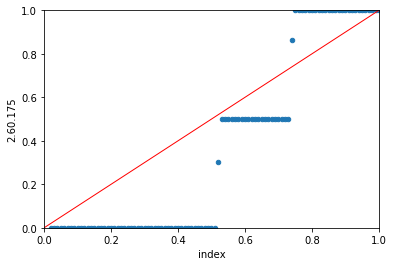

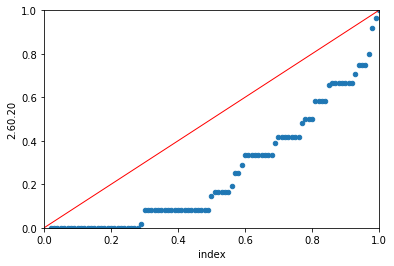

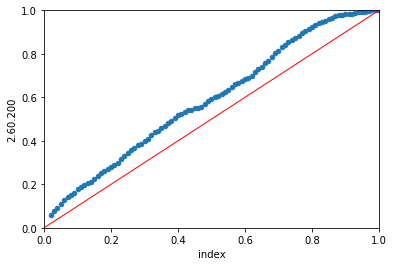

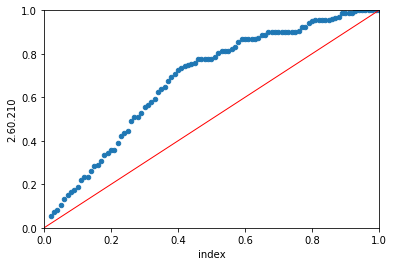

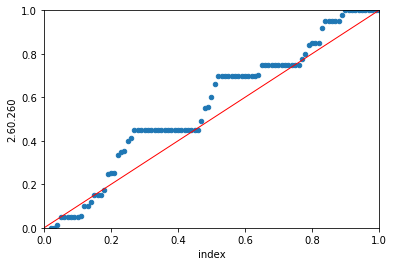

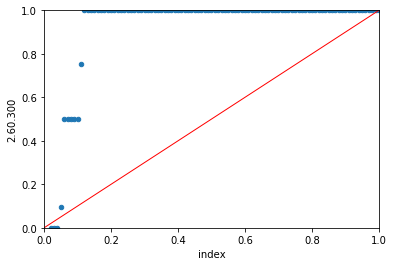

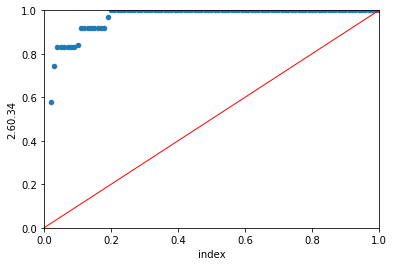

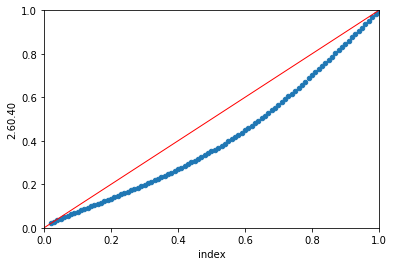

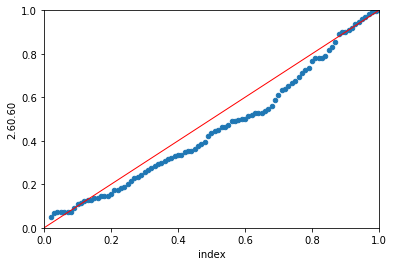

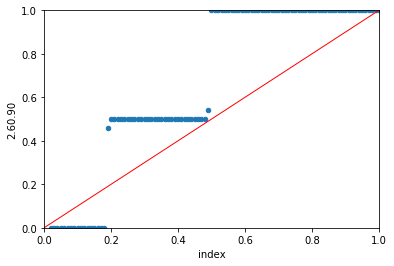

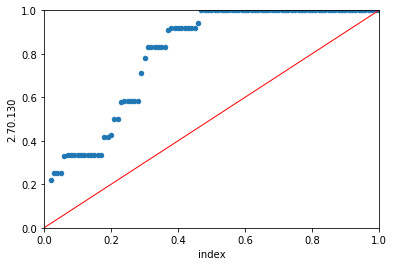

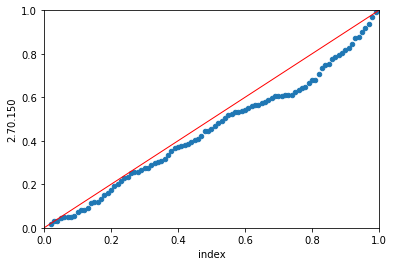

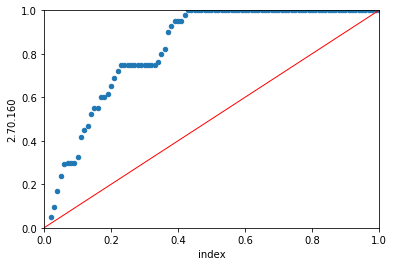

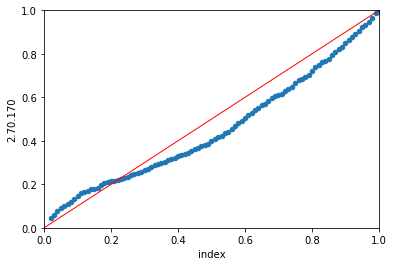

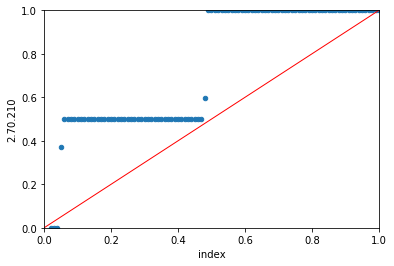

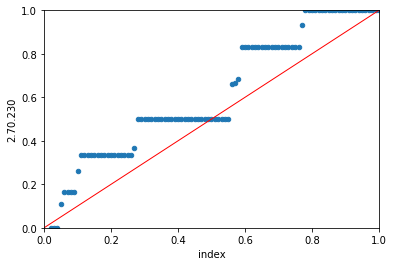

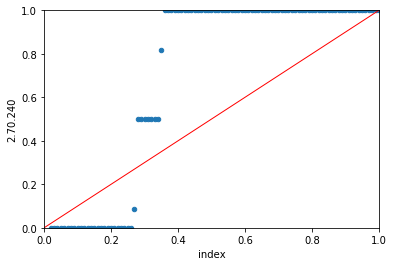

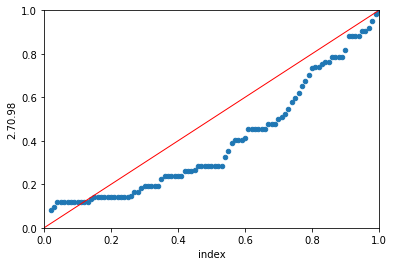

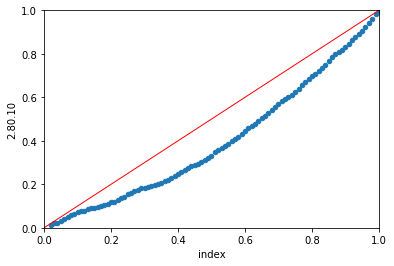

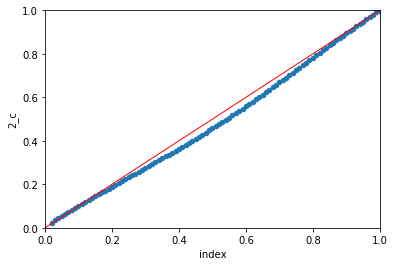

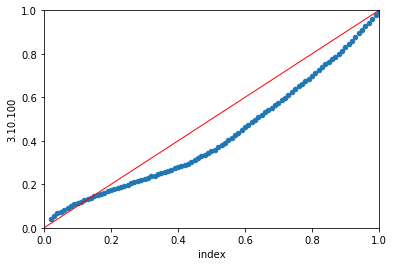

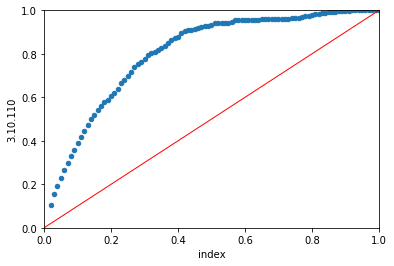

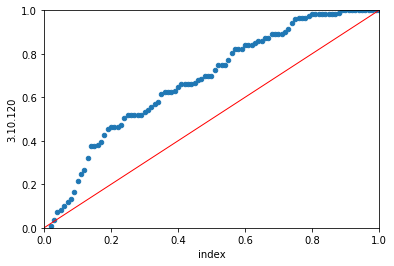

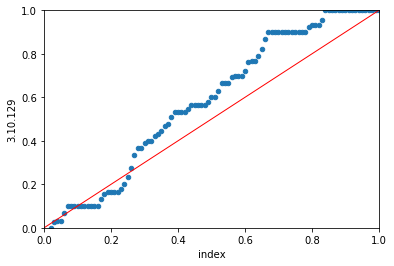

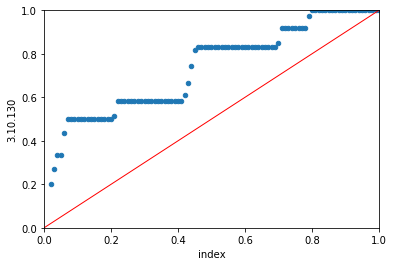

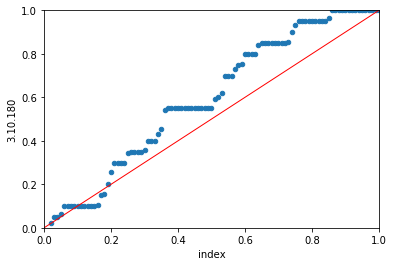

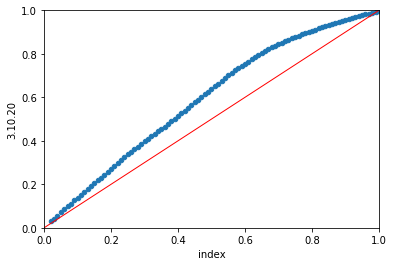

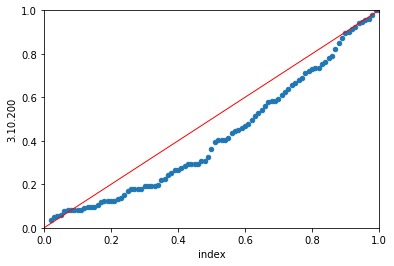

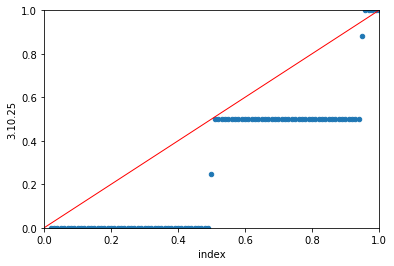

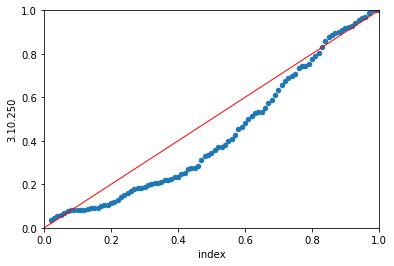

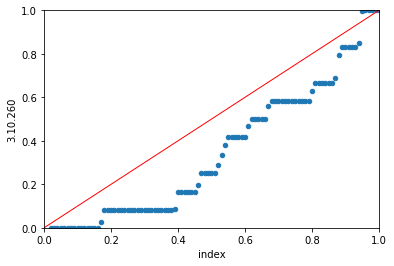

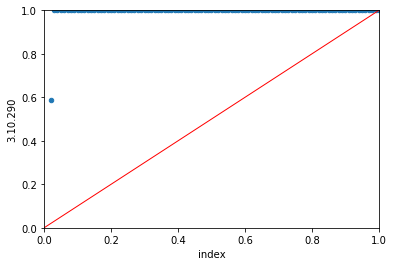

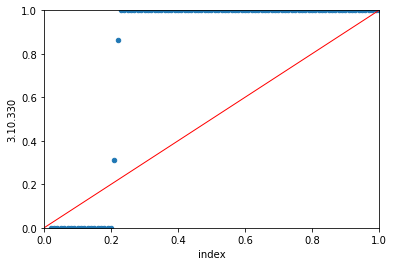

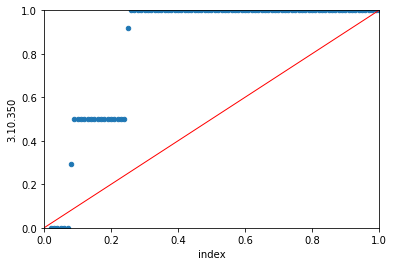

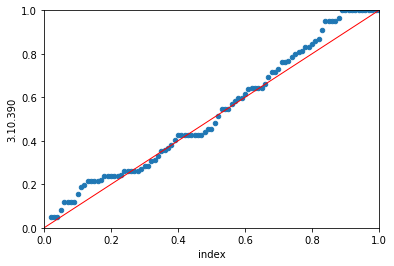

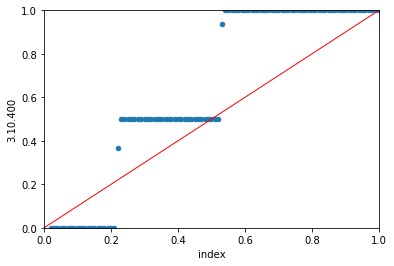

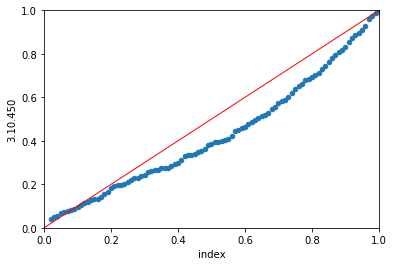

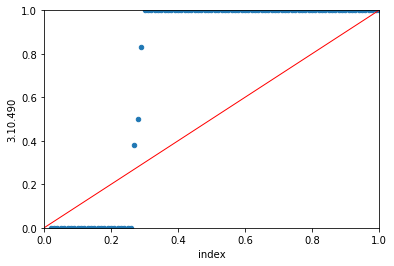

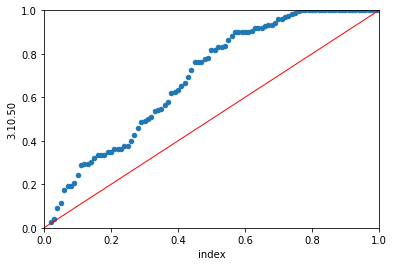

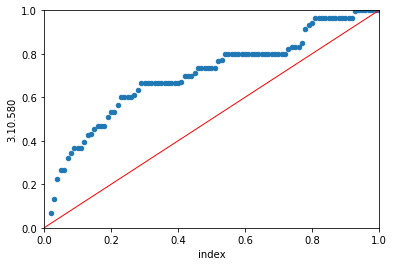

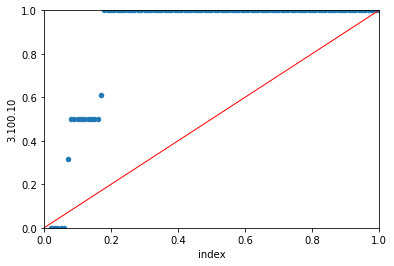

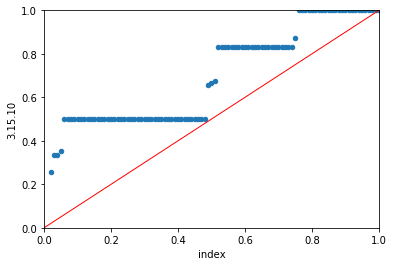

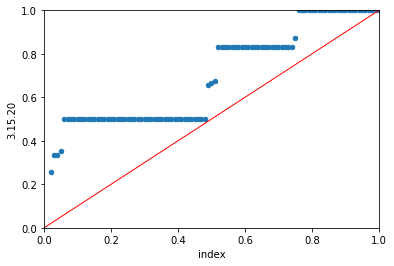

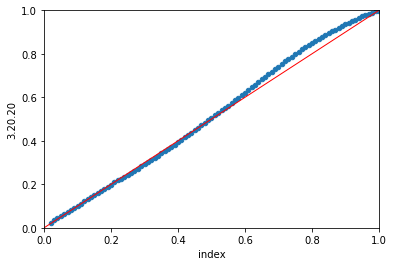

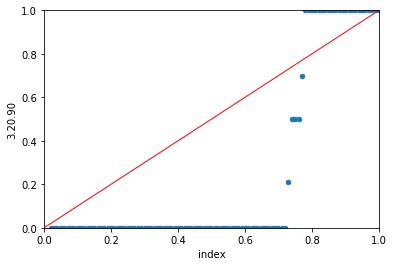

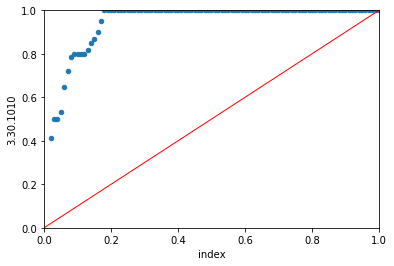

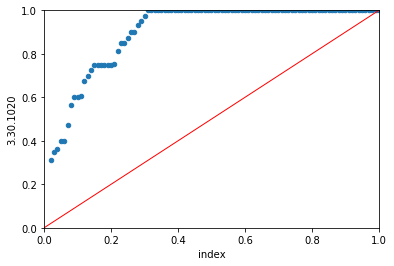

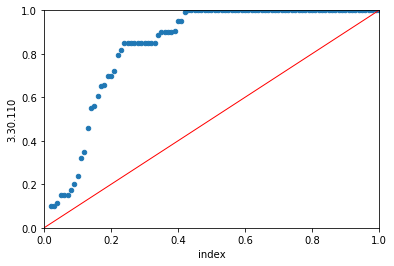

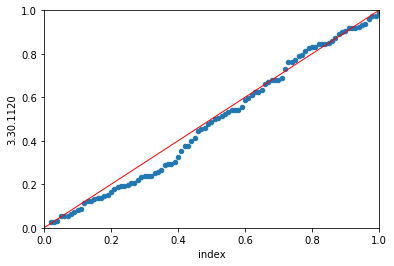

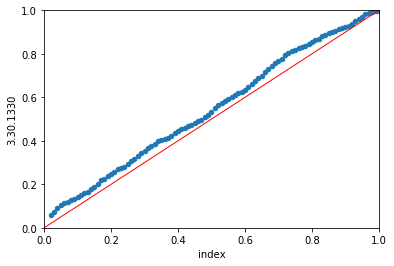

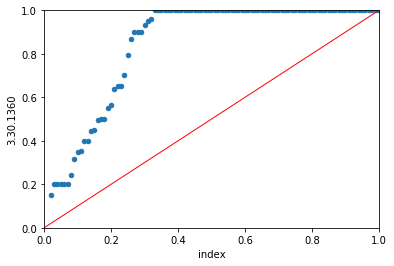

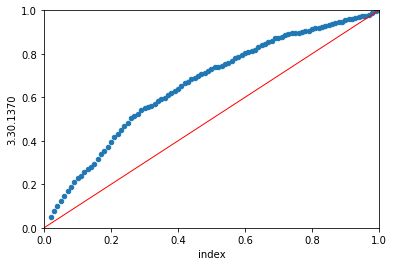

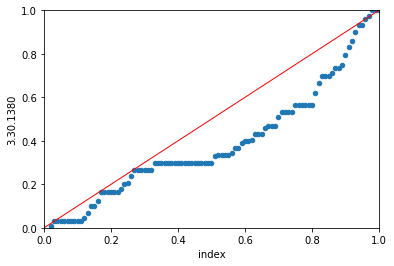

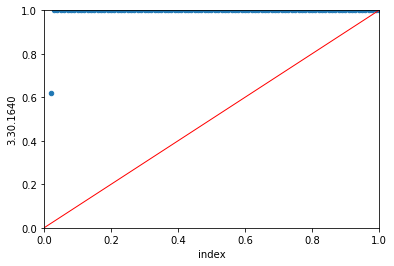

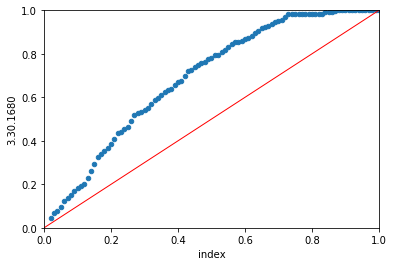

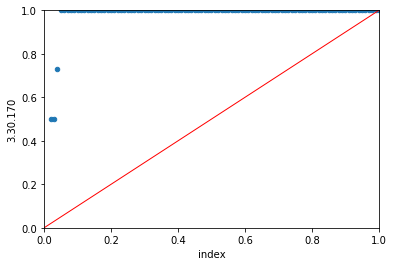

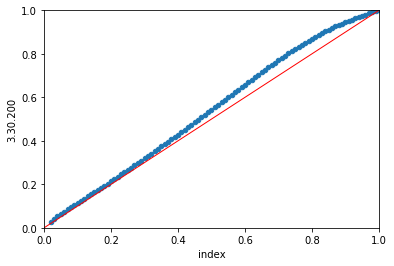

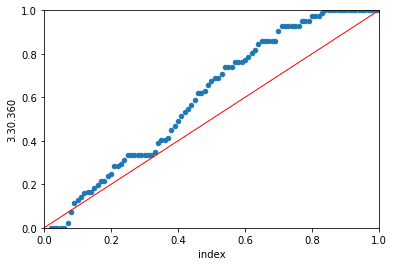

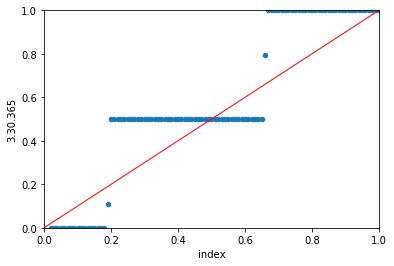

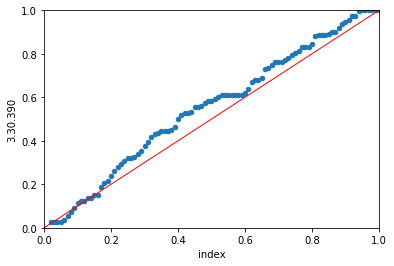

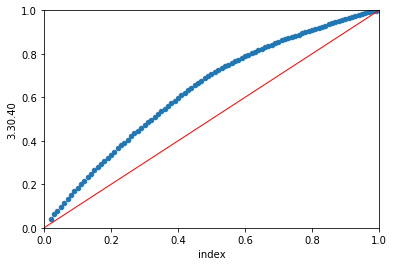

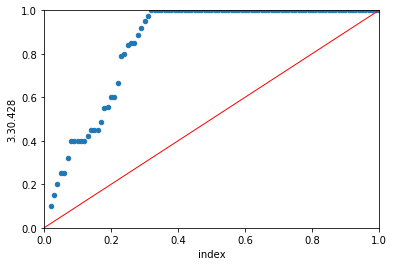

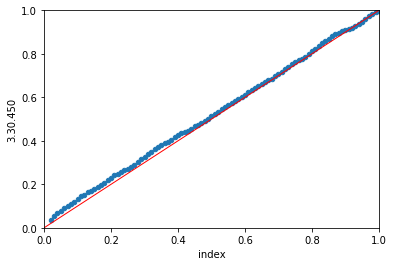

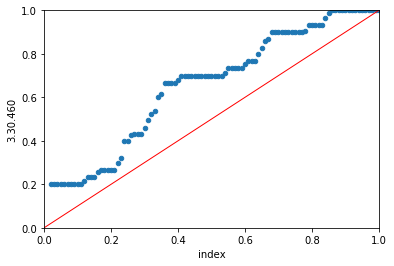

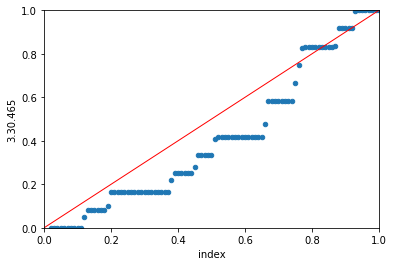

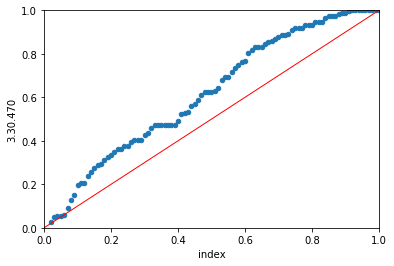

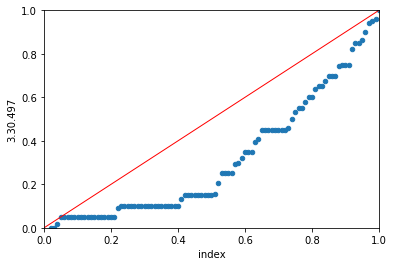

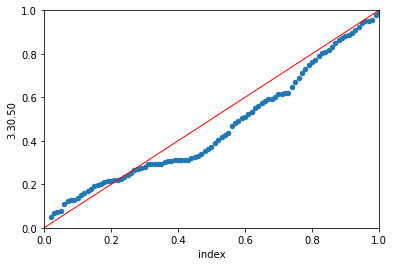

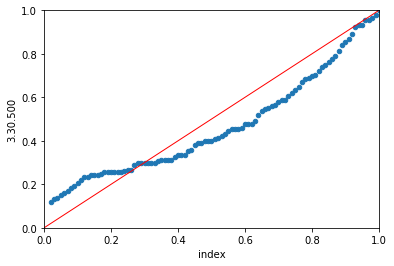

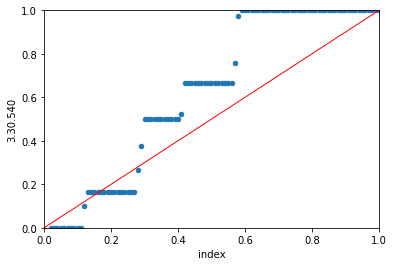

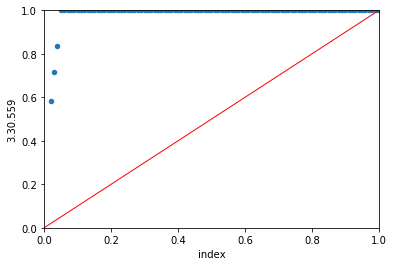

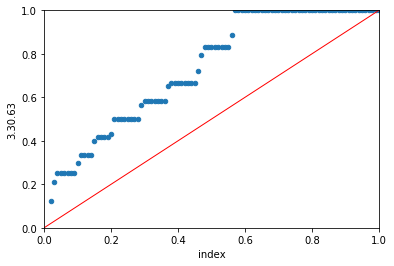

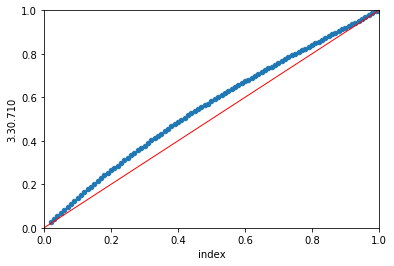

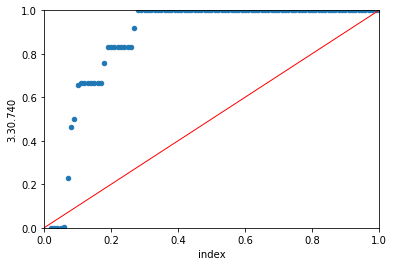

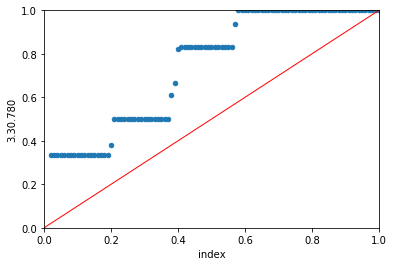

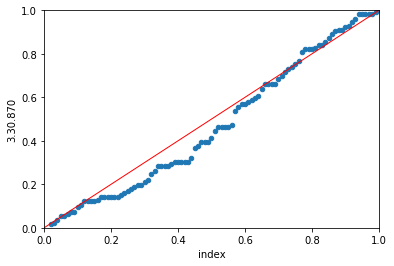

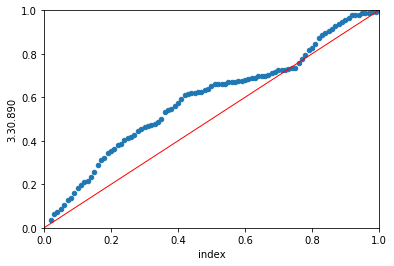

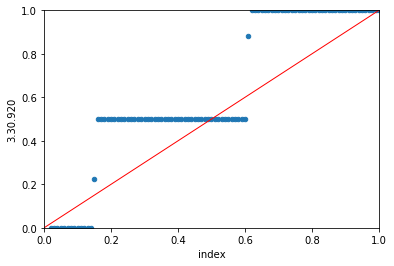

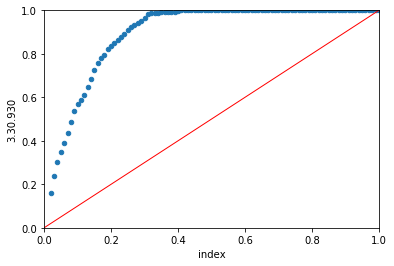

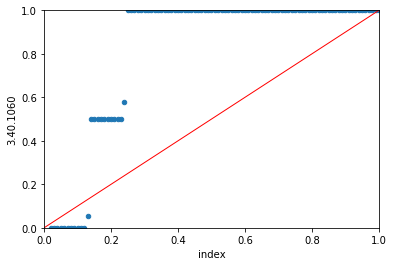

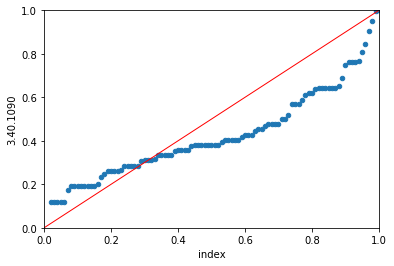

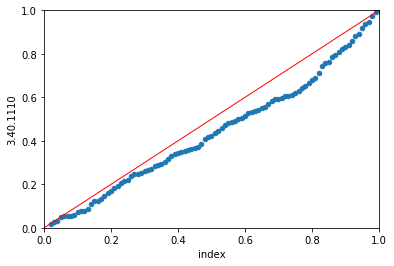

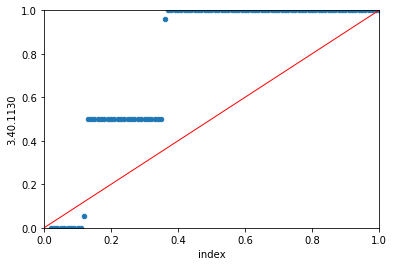

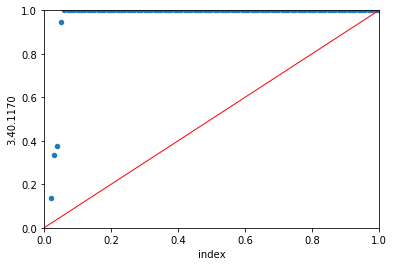

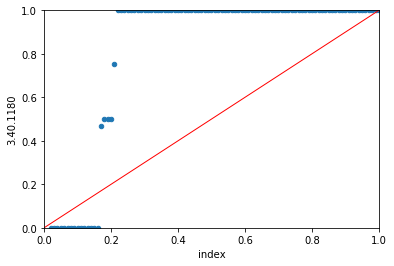

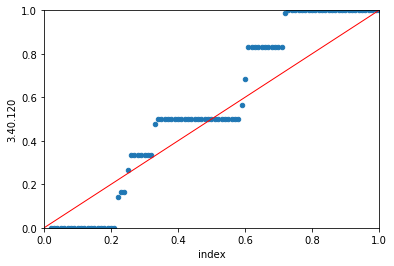

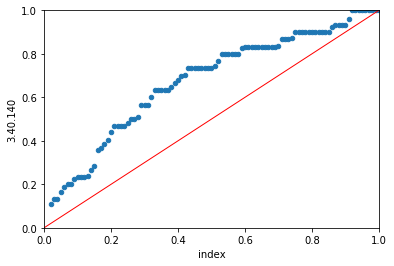

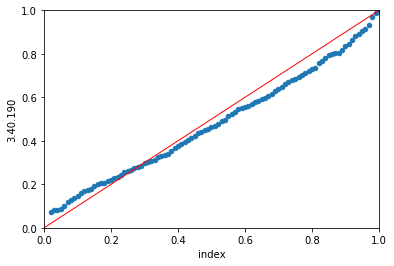

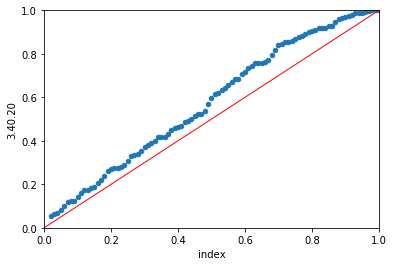

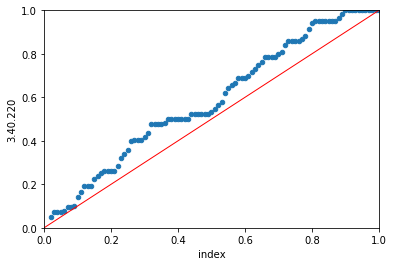

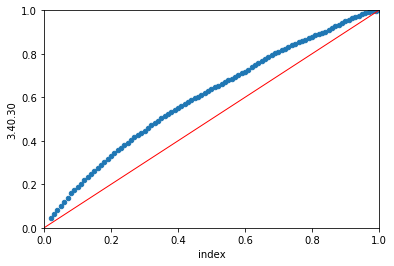

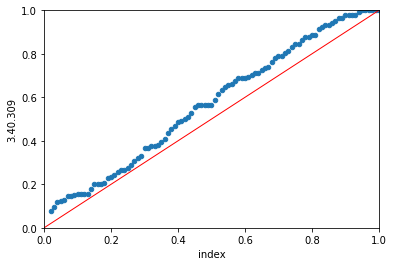

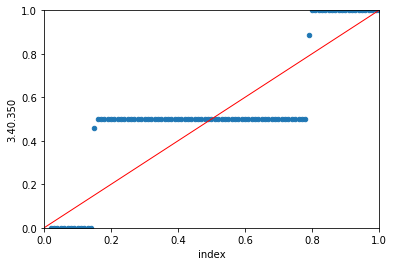

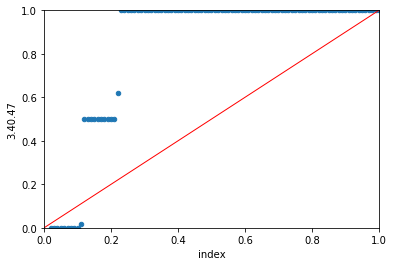

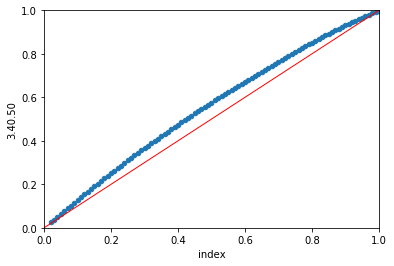

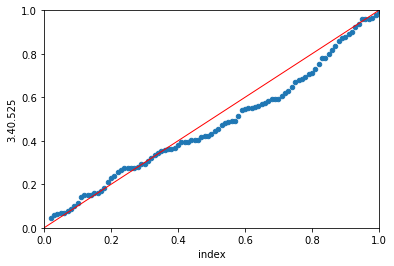

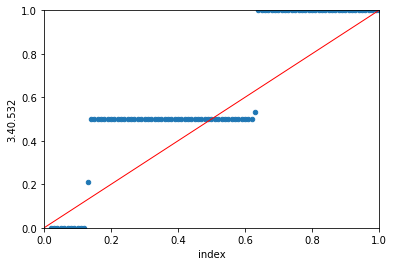

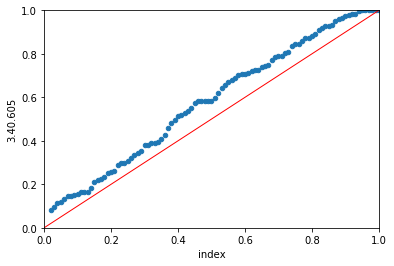

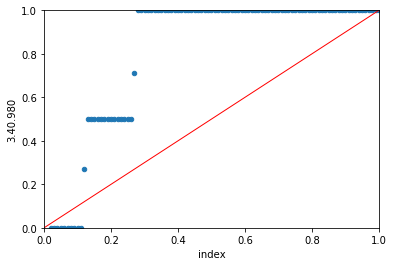

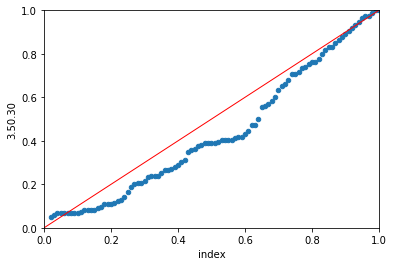

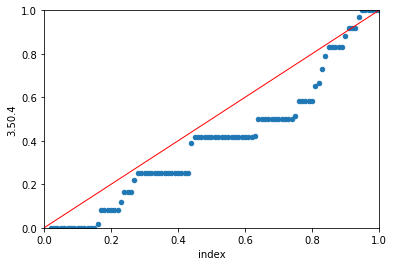

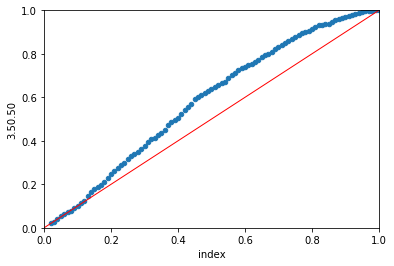

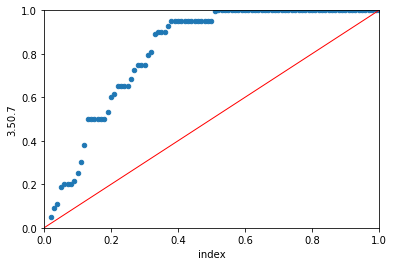

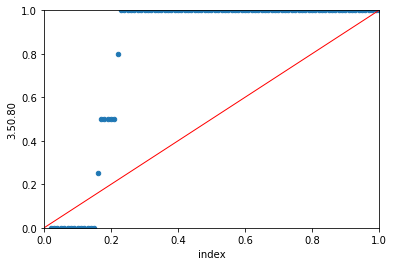

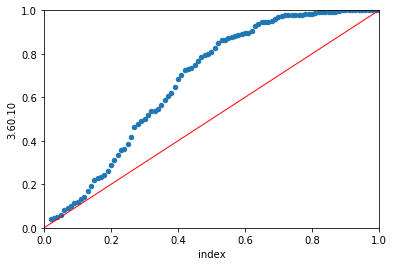

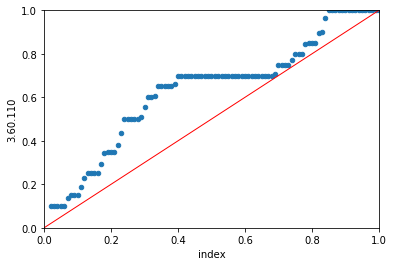

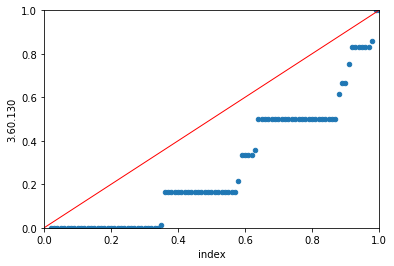

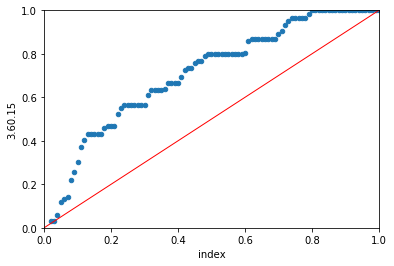

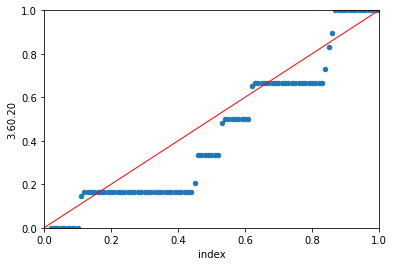

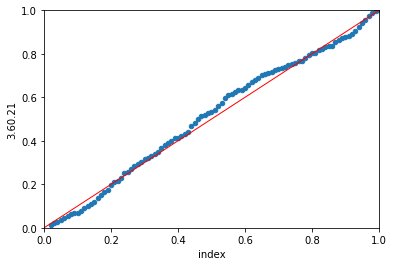

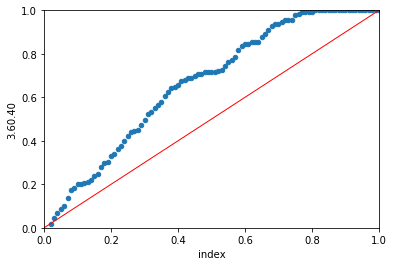

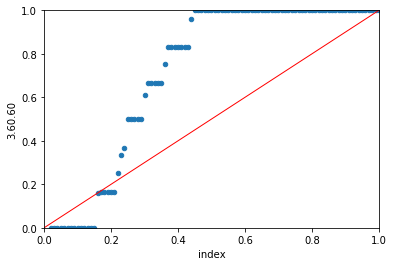

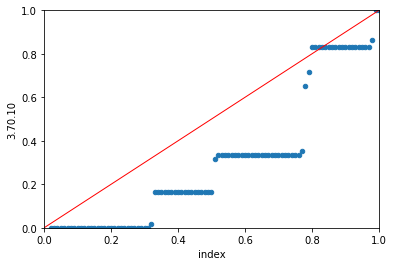

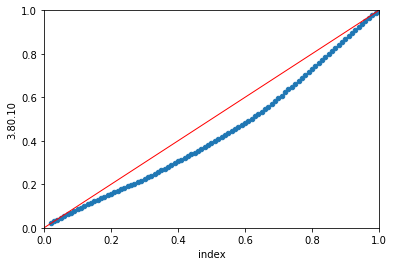

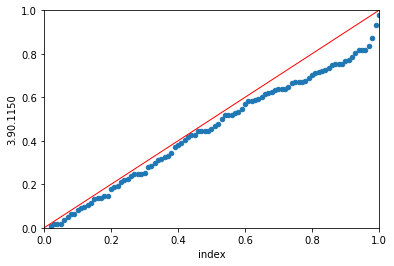

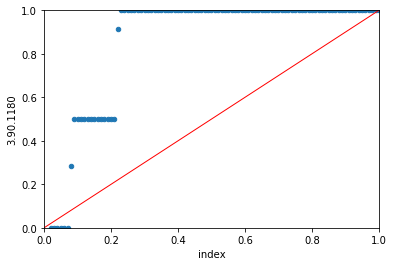

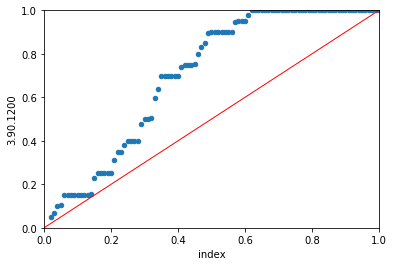

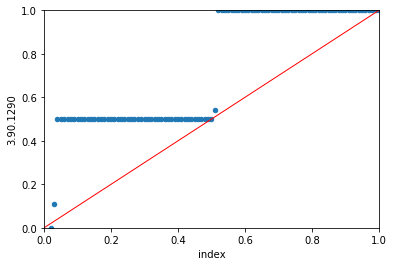

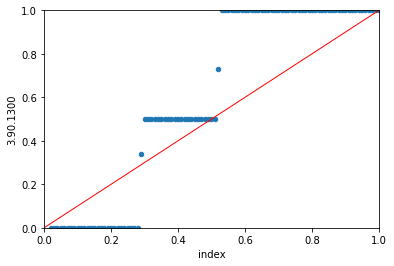

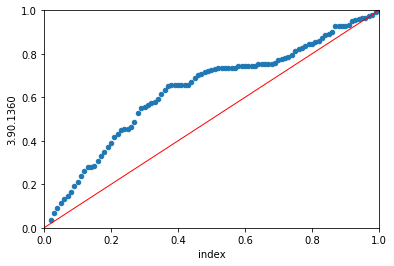

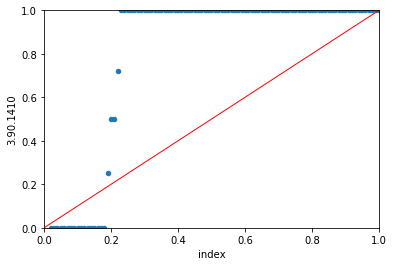

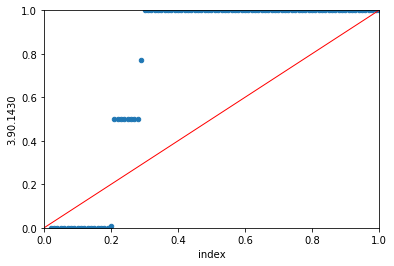

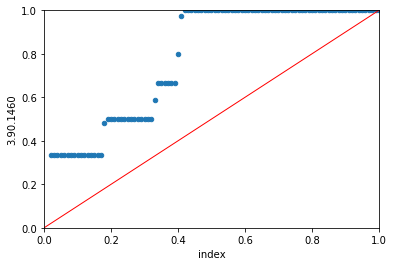

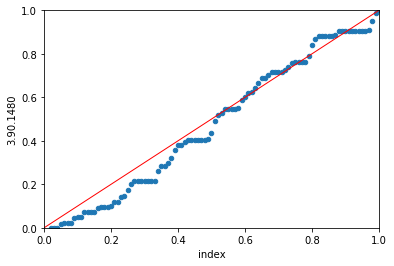

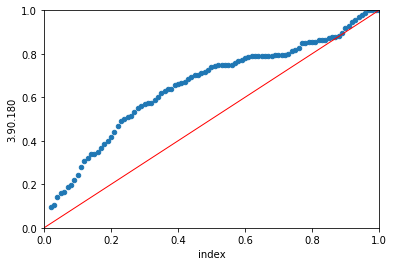

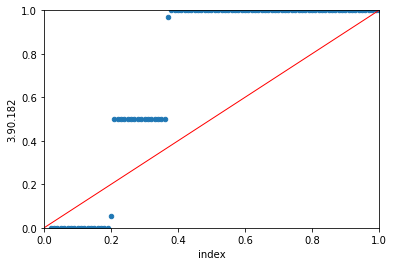

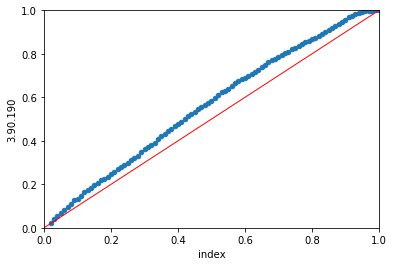

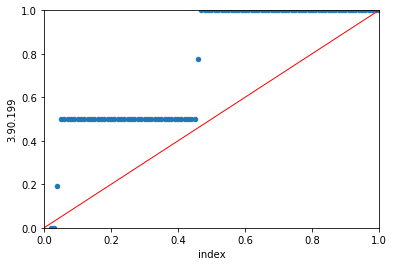

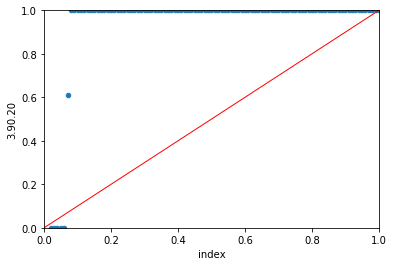

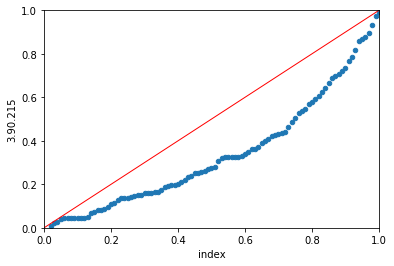

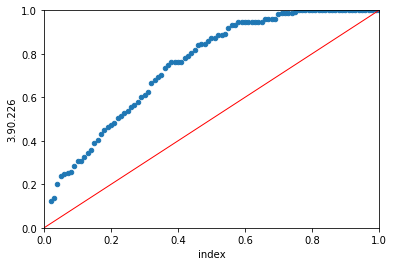

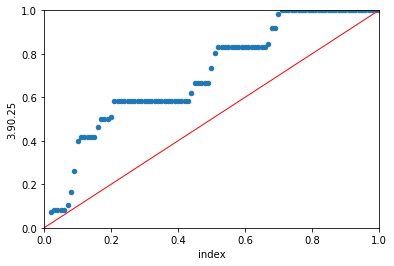

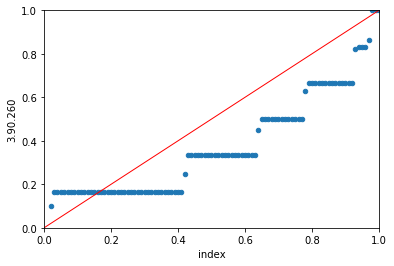

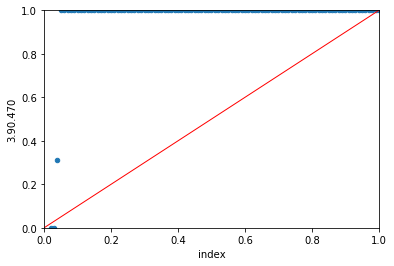

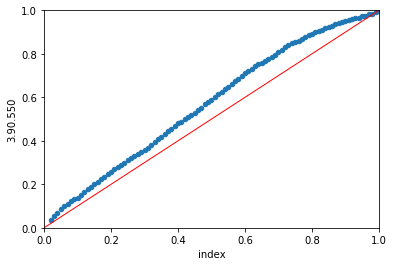

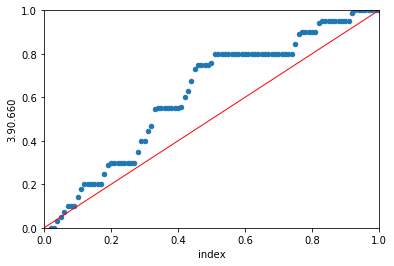

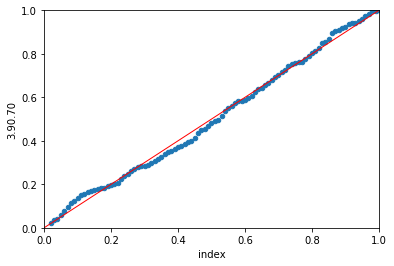

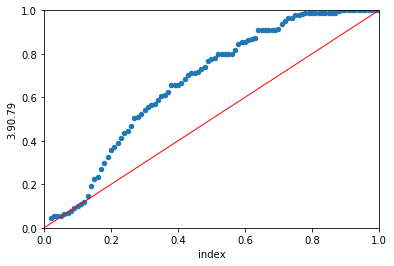

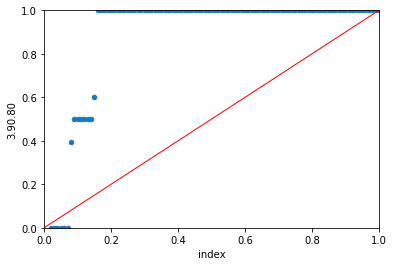

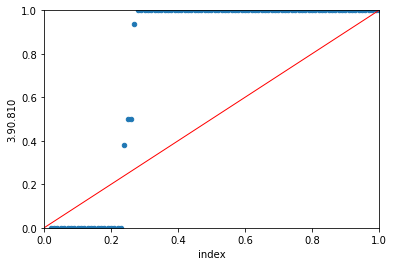

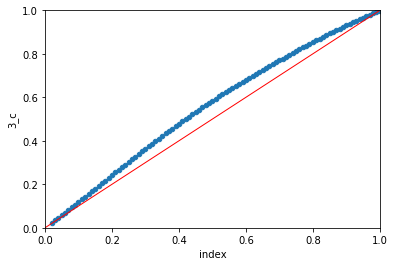

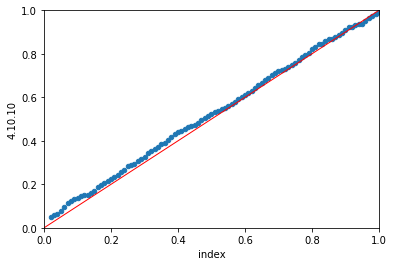

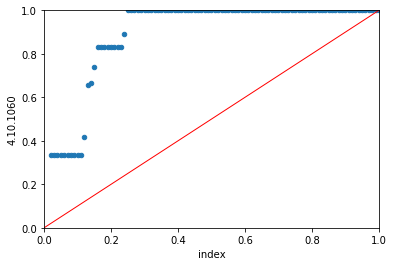

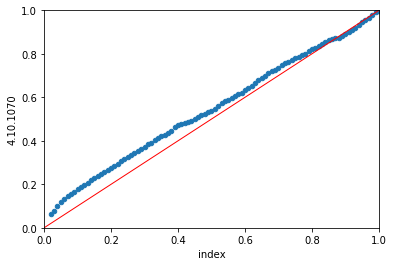

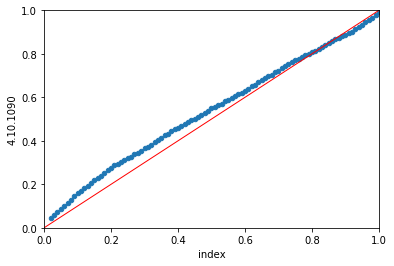

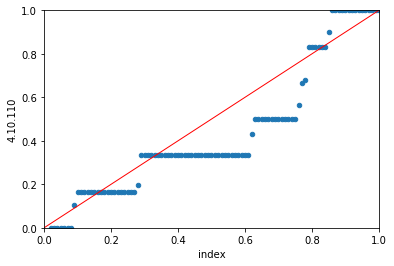

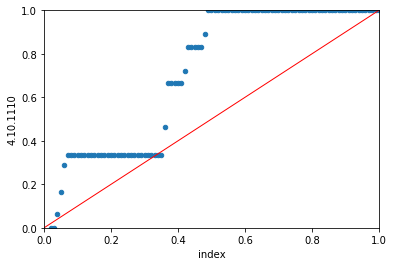

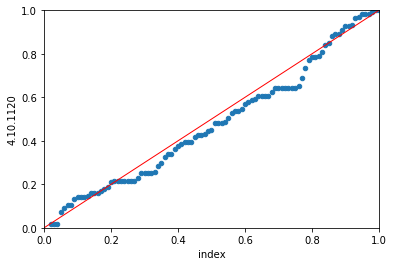

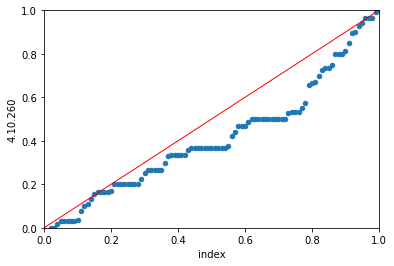

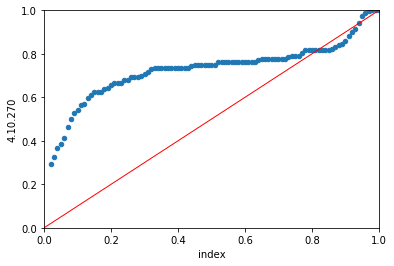

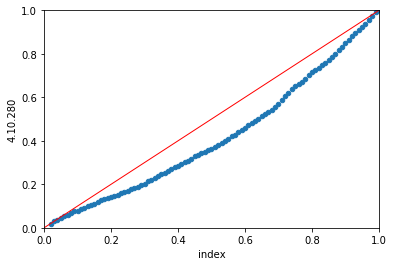

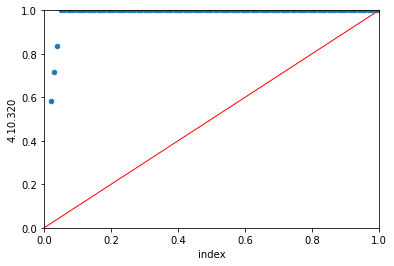

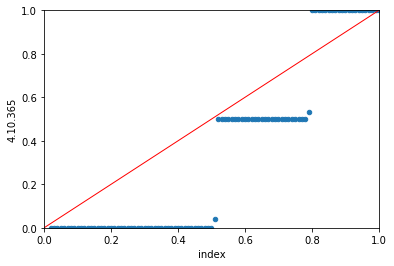

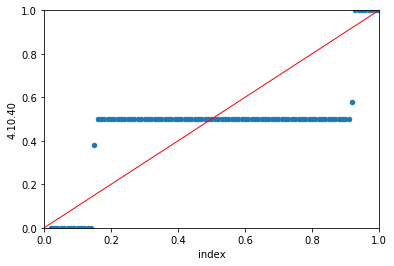

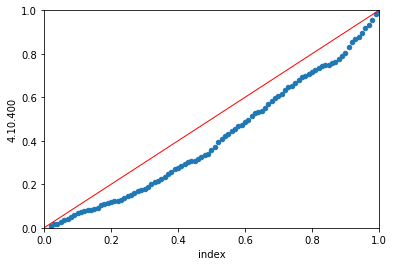

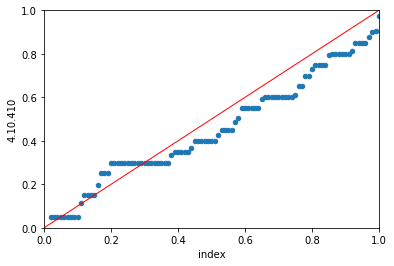

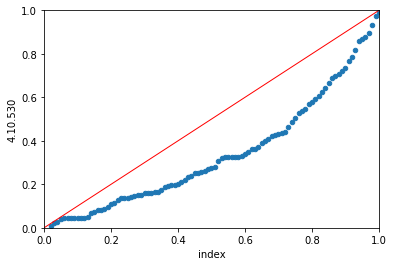

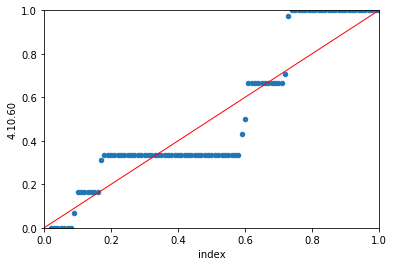

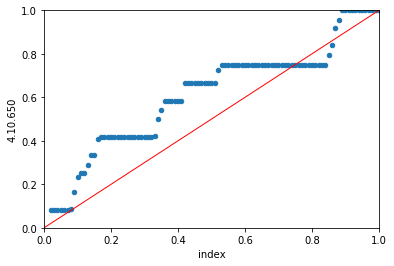

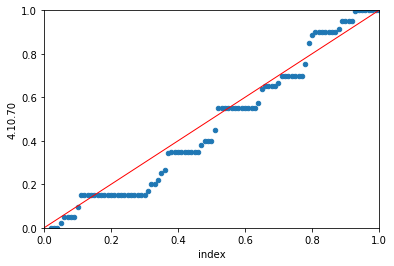

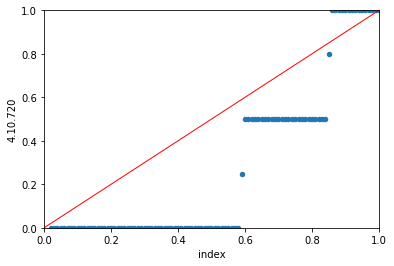

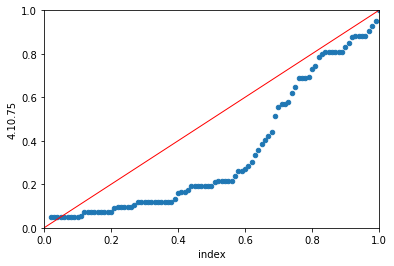

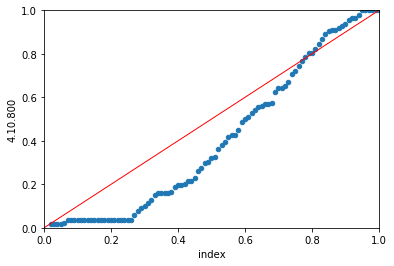

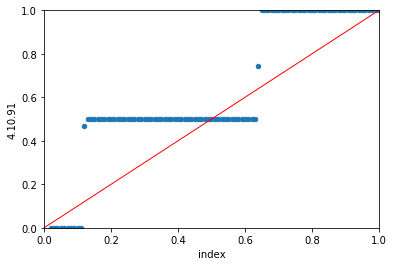

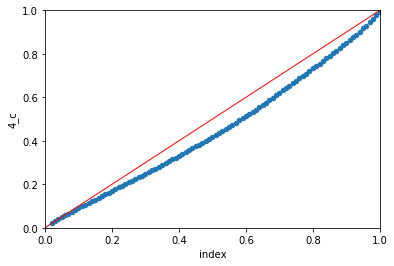

In [72]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[8::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

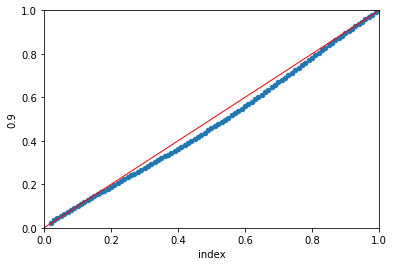

In [89]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[8::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

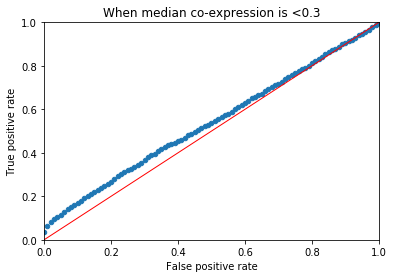

In [799]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[8::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    axes.set_title('When median co-expression is <0.3')
    #axes.set_title('Randomly picked first true positive')
    #axes.yaxis.grid(True)
    axes.set_xlabel('False positive rate')
    axes.set_ylabel('True positive rate')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

In [756]:
df_scores[df_scores.auc == df_scores.auc.max()].sample()
df_scores.at[3148, 'threshold'] = 10

threshold  auc                    pr_curve  true_pos  true_neg  \
102         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
688         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
787         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
1449        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
1482        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
1648        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2052        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2182        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2213        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2215        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2238        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2608        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2670        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2791        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2904        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3148       10.0  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3229        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
4423        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
4968        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
5261        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
6091        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   

     prot_name  exp_median  exp_mean   exp_var top_match_protein  ... 0.91  \
102     P19957    0.063144  0.097789  0.010804            P03973  ...  1.0   
688     P10720    0.108527  0.125617  0.009718            P02776  ...  1.0   
787     P05109    0.160091  0.205600  0.035653            P06702  ...  1.0   
1449    Q9UKX2    0.037367  0.050004  0.001963            P12882  ...  1.0   
1482    Q6EIG7    0.120128  0.150746  0.017268            Q8WXI8  ...  1.0   
1648    Q9Y663    0.291072  0.286251  0.025071            Q9Y662  ...  1.0   
2052    P51878    0.115020  0.157309  0.022025            Q5EG05  ...  1.0   
2182    P01583    0.128079  0.150967  0.013791            P01584  ...  1.0   
2213    P25025    0.249596  0.259982  0.033039            P25024  ...  1.0   
2215    P29016    0.124749  0.135798  0.010183            P29017  ...  1.0   
2238    P12724    0.129384  0.146813  0.012086            P10153  ...  1.0   
2608    P22079    0.214048  0.211277  0.012520            P05164  ...  1.0   
2670    Q15166    0.196068  0.197422  0.011425            P27169  ...  1.0   
2791    Q99616    0.089441  0.117680  0.011231            P80075  ...  1.0   
2904    Q9BZM6    0.240533  0.240375  0.022635            Q9BZM5  ...  1.0   
3148    P19429    0.080303  0.102784  0.007273            P13805  ...  1.0   
3229    P02775    0.099480  0.119808  0.010667            P02776  ...  1.0   
4423    P49888    0.052126  0.070029  0.004001            O43704  ...  1.0   
4968    P27169    0.149954  0.164560  0.011374            Q15166  ...  1.0   
5261    P10153    0.201924  0.220043  0.028794            P12724  ...  1.0   
6091    Q99879    0.104365  0.122788  0.010541            Q99880  ...  1.0   

     0.92  0.93  0.94  0.95  0.96  0.97  0.98  0.99  1.0  
102   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
688   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
787   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
1449  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
1482  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
1648  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2052  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2182  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2213  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2215  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0  
2238  1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.

In [754]:
df_scores.at[3148, 'threshold'] = 10

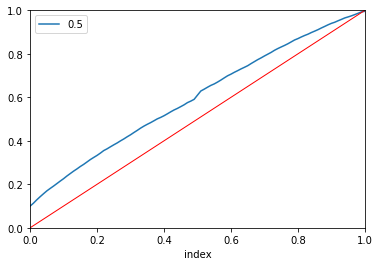

In [946]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[6::].plot(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

In [301]:
df_plot

threshold                                       0.5
auc                                         0.98001
pr_curve     {0.0: 0.0, 1.0: 0.0006534048274245737}
true_pos                                          1
true_neg                                       6103
                              ...                  
0.96                                              1
0.97                                              1
0.98                                              1
0.99                                              1
1.0                                               1
Name: 3, Length: 114, dtype: object

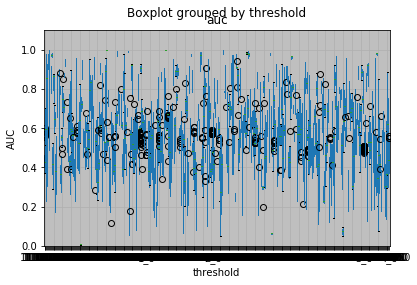

In [62]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='threshold', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

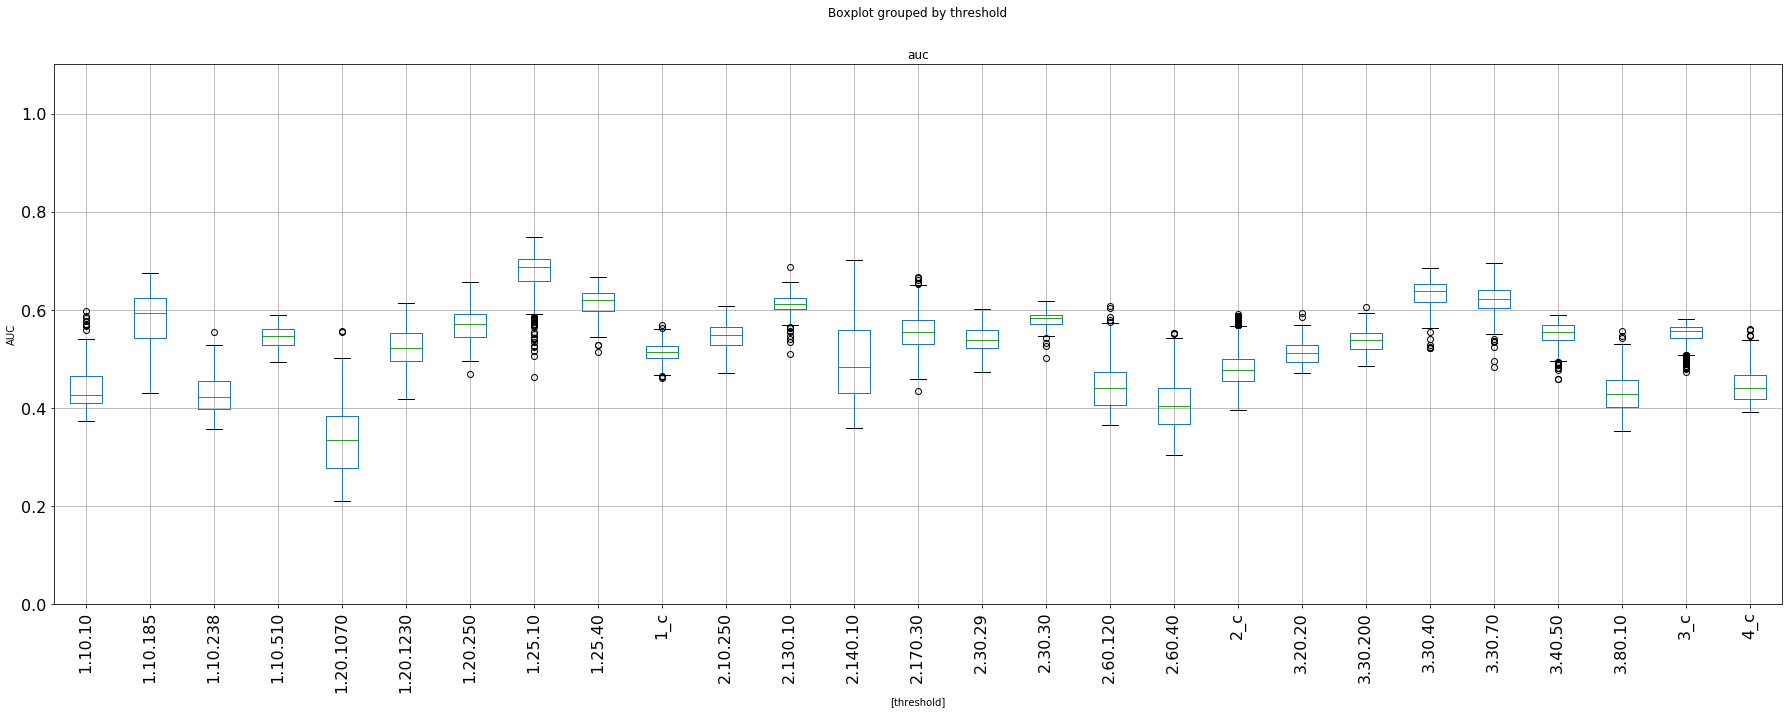

In [113]:
fig, axes = plt.subplots(figsize=(30,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by=['threshold'], ax=axes,  rot=90, fontsize=16)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [110]:
df_scores['exp_median'] = df_scores['exp_median'].round(1)

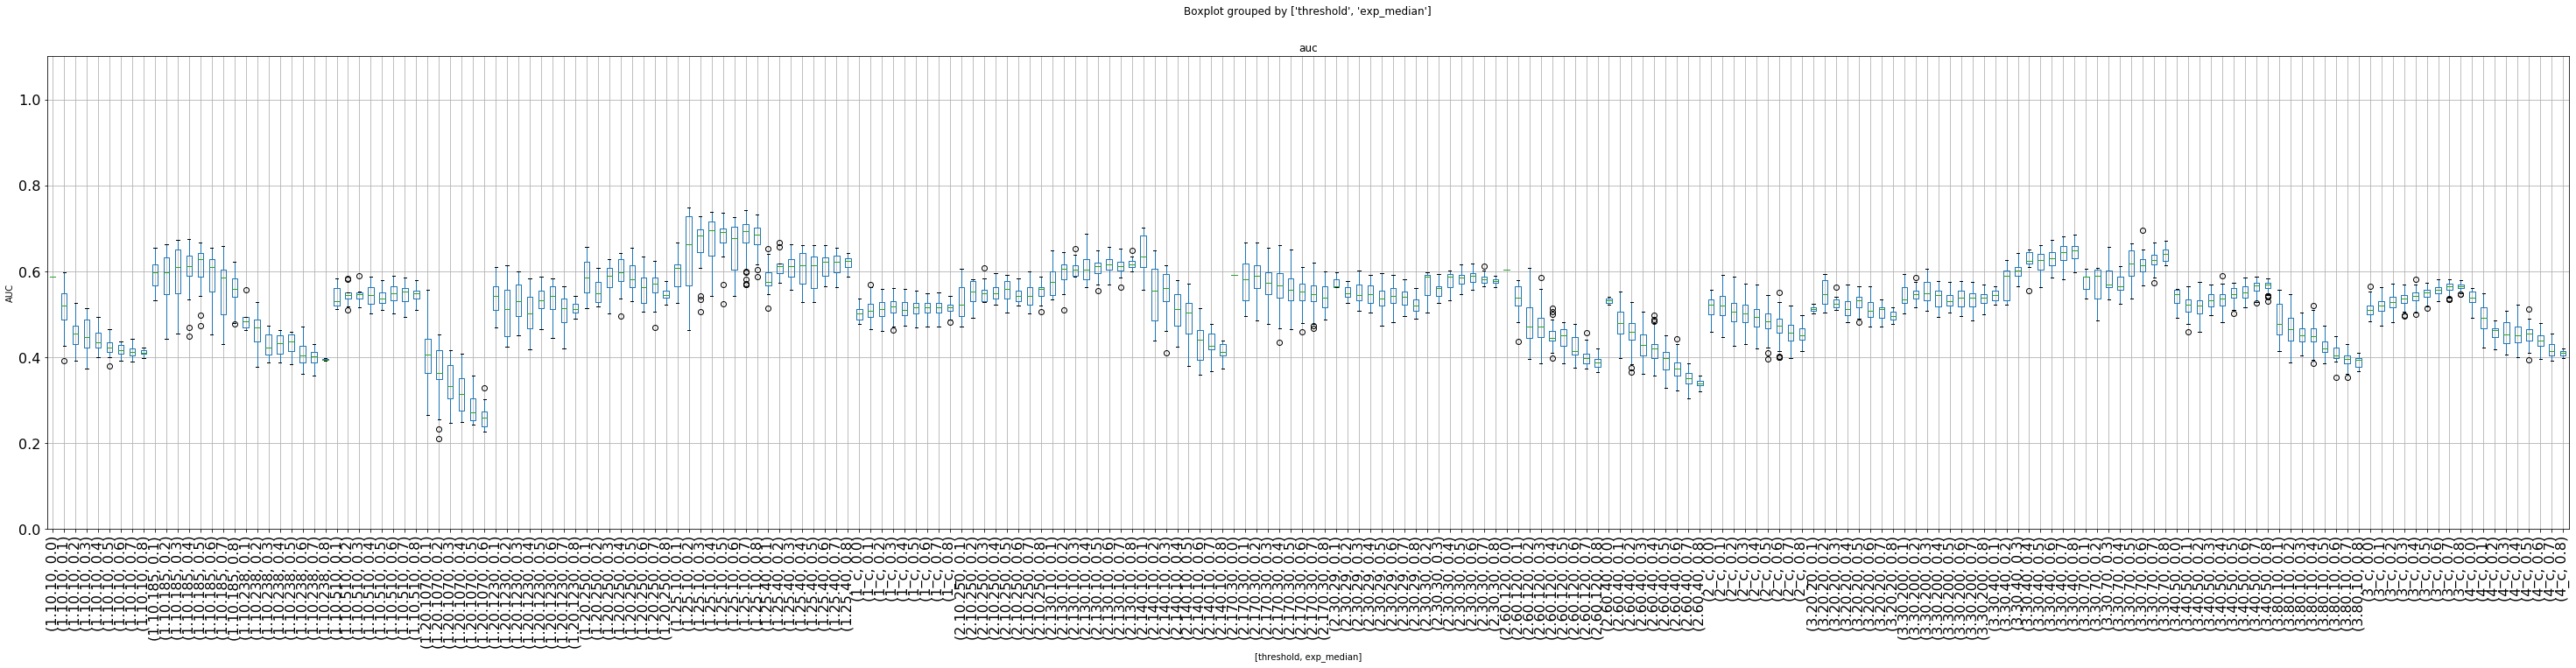

In [111]:
fig, axes = plt.subplots(figsize=(50,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by=['threshold', 'exp_median'], ax=axes,  rot=90, fontsize=16)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

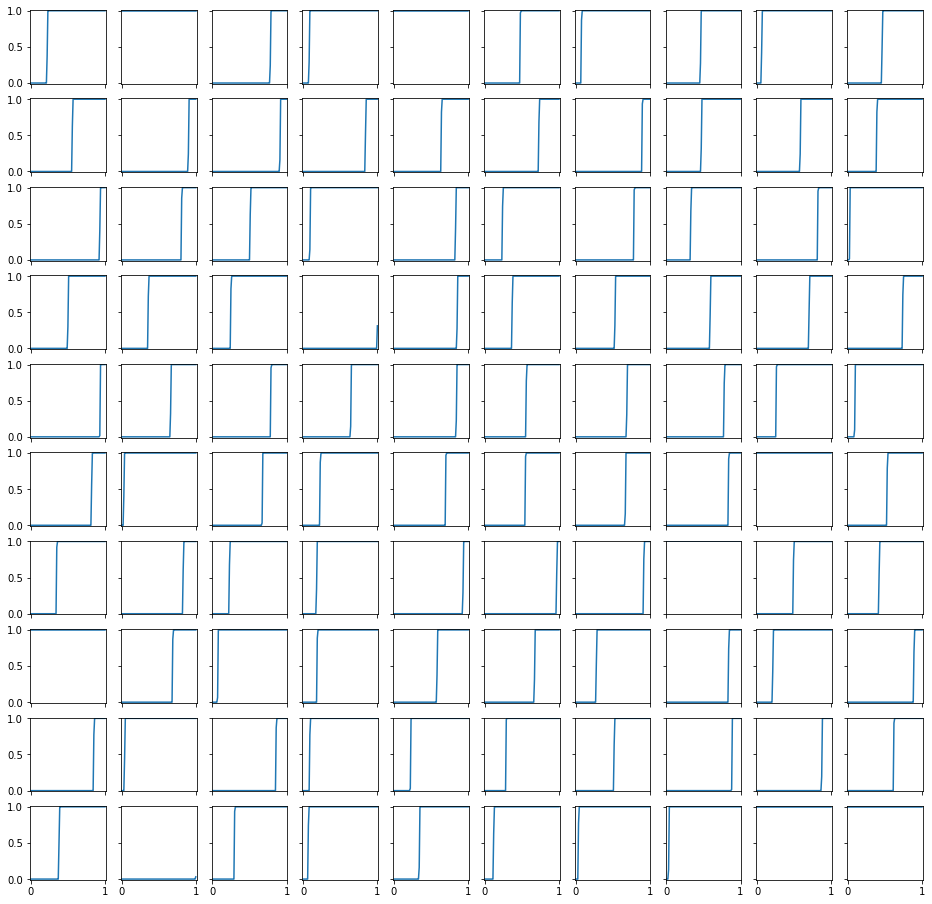

In [315]:
fig, axes = plt.subplots(10,10, sharex=True, sharey=True)
for thresh, ax  in zip(range(0,100), axes.flatten()): 
    
    df_plot = df_scores.iloc[thresh]
    #df_plot = df_scores.iloc[thresh]
    ax.plot(*zip(*sorted(df_plot['plot'].items())))
    #if (df_plot['prot_name'] == 'Q8WUP2'):
    #ax.plot(*zip(*sorted(df_scores['plot'].items())))
    #df_plot = pd.concat([df_plot.drop(['plot'], axis=1), df_plot['plot'].apply(pd.Series)], axis=1)
    #ax = df_plot.T.reset_index().plot(x='index', y=thresh)
    #ax.plot([0, 1], [0, 1], 'red', linewidth=1)
        #ax = df_plot.T.reset_index().plot(x='index', y=0.3)
        #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
        #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
        #axes.set_title('Predicting structure similarity from expression')
        #axes.yaxis.grid(True)
        #axes.set_xlabel('Co-expression')
        #axes.set_ylabel('AUC')
        #axes.set_ylim([0.0,1.101])
        #plt.setp(bp['fliers'], markersize=3.0)
        #0.5
        #fig, axes = plt.subplots()
        #axes.scatter(x, y)
        #axes.plot(x, y)
        #break
ax.set_ylim([-0.01,1.01])
ax.set_xlim([-0.01,1.01])
fig.set_size_inches(16,16)
#plt.show()
plt.show()

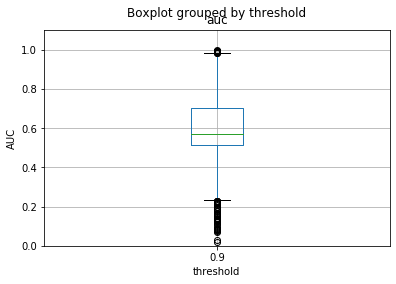

In [184]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='threshold', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [125]:
pwd

'/data/lohia/EGAD_analysis/egad_cath'

In [126]:
uid_protname_db.to_csv("/data/lohia/EGAD_analysis/egad_cath/protein_auc", index=False)


threshold  auc                                               plot  \
2           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
3           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
4           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
6           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
...         ...  ...                                                ...   
5598        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5712        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5771        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5891        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5909        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   

                        pr_curve  true_pos  true_neg prot_name  exp_median  \
2     {1.0: 0.00152260765876942}       1.0      6103    P17509    0.170735   
3     {1.0: 0.00152260765876942}       1.0      6103    P31273    0.085531   
4     {1.0: 0.00152260765876942}       1.0      6103    P09067    0.108086   
5     {1.0: 0.00152260765876942}       1.0      6103    P09629    0.414260   
6     {1.0: 0.00152260765876942}       1.0      6103    P09630    0.103786   
...                          ...       ...       ...       ...         ...   
5598  {1.0: 0.00152260765876942}       1.0      6103    P27169    0.149954   
5712  {1.0: 0.00152260765876942}       1.0      6103    Q13823    0.749797   
5771  {1.0: 0.00152260765876942}       1.0      6103    Q9NR12    0.476361   
5891  {1.0: 0.00152260765876942}       1.0      6103    Q96NU0    0.215091   
5909  {1.0: 0.00152260765876942}       1.0      6103    P35612    0.520241   

      exp_mean   exp_var  ...        cath_x   residues_x pdb_chain_domain_y  \
2     0.172980  0.009705  ...    1.10.10.60     88-160:A            1b8iA00   
3     0.090403  0.002681  ...    1.10.10.60     88-160:A            1b8iA00   
4     0.115854  0.004691  ...    1.10.10.60     88-160:A            1b8iA00   
5     0.384499  0.032055  ...    1.10.10.60     88-160:A            1b8iA00   
6     0.112479  0.004651  ...    1.10.10.60     88-160:A            1b8iA00   
...        ...       ...  ...           ...          ...                ...   
5598  0.164560  0.011374  ...   2.120.10.30     16-355:A            1v04A00   
5712  0.678995  0.074410  ...   3.40.50.300     12-179:A            1pujA01   
5771  0.463833  0.056655  ...   2.10.110.10       1-66:A            1nypA00   
5891  0.224673  0.017884  ...  2.60.120.200  2695-2870:A            2jd4A02   
5909  0.483304  0.039663  ...   3.40.225.10      1-206:P            1k0wA00   

     version_y        cath_y   residues_y Entry_x  \
2       v4_2_0    1.10.10.60     88-160:A  P17509   
3       v4_2_0    1.10.10.60     88-160:A  P31273   
4       v4_2_0    1.10.10.60     88-160:A  P09067   
5       v4_2_0    1.10.10.60     88-160:A  P09629   
6       v4_2_0    1.10.10.60     88-160:A  P09630   
...        ...           ...          ...     ...   
5598    v4_2_0   2.120.10.30     16-355:A  P27169   
5712    v4_2_0   3.40.50.300     12-179:A  Q13823   
5771    v4_2_0   2.10.110.10       1-66:A  Q9NR12   
5891    v4_2_0  2.60.120.200  2695-2870:A  Q96NU0   
5909    v4_2_0   3.40.225.10      1-223:A  P35612   

                                        Protein names_x Entry_y  \
2     Homeobox protein Hox-B6 (Homeobox protein Hox-...  P31269   
3     Homeobox protein Hox-C8 (Homeobox protein Hox-3A)  P31269   
4     Homeobox protein Hox-B5 (Homeobox protein HHO....  P17483   
5     Homeobox protein Hox-B7 (Homeobox protein HHO....  P17483   
6     Homeobox protein Hox-C6 (Homeobox protein CP25...  P09629   
...                                                 ...     ...   
5598  Serum paraoxonase/arylesterase 1 (PON 1) (EC 3...  Q15166   
5712  Nucleolar GTP-binding protein 2 (Autoant

In [284]:
uid_protname_db_1 = df_scores[df_scores['auc'] == 1]

In [285]:
uid_protname_db_1

threshold  auc                                               plot  \
1           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
89          0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
93          0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
102         0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
...         ...  ...                                                ...   
5989        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
6004        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
6046        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
6056        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
6091        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   

                        pr_curve  true_pos  true_neg prot_name  exp_median  \
1     {1.0: 0.00152260765876942}       1.0      6103    P17509    0.170735   
5     {1.0: 0.00152260765876942}       1.0      6103    Q5VT97    0.525132   
89    {1.0: 0.00152260765876942}       1.0      6103    P02795    0.331871   
93    {1.0: 0.00152260765876942}       1.0      6103    P50851    0.698861   
102   {1.0: 0.00152260765876942}       1.0      6103    P19957    0.063144   
...                          ...       ...       ...       ...         ...   
5989  {1.0: 0.00152260765876942}       1.0      6103    O00160    0.512544   
6004  {1.0: 0.00152260765876942}       1.0      6103    Q9UIU6    0.319150   
6046  {1.0: 0.00152260765876942}       1.0      6103    P13533    0.047974   
6056  {1.0: 0.00152260765876942}       1.0      6103    P68366    0.498516   
6091  {1.0: 0.00152260765876942}       1.0      6103    Q99879    0.104365   

      exp_mean   exp_var top_match_protein dom_pair_a dom_pair_b  \
1     0.172980  0.009705            P31269    1b8iA00    1b8iA00   
5     0.505171  0.063083            Q68EM7    1s58A00    1f7cA00   
89    0.334737  0.051302            O75095    4mt2A00    4mt2A00   
93    0.641930  0.071126            O14497    1s58A00    1s58A00   
102   0.097789  0.010804            P03973    2z7fI00    2z7fI00   
...        ...       ...               ...        ...        ...   
5989  0.487958  0.059743            Q9P2N5    1jvrA00    1jvrA00   
6004  0.313272  0.023808            Q99697    1fjlB00    1fjlB00   
6046  0.059615  0.002307            Q9UKX3    1wdcA00    1wdcA00   
6056  0.473386  0.057585            Q9UJT1    1tvkA03    1tvkA03   
6091  0.122788  0.010541            Q99880    1tzyF00    1tzyF00   

      real_tm_score  
1               1.0  
5               1.0  
89              1.0  
93              1.0  
102             1.0  
...             ...  
5989            1.0  
6004            1.0  
6046            1.0  
6056            1.0  
6091            1.0  

[286 rows x 14 columns]

In [286]:
uid_protname_db_1['Protein names_y'].value_counts() 

KeyError: 'Protein names_y'

In [291]:
uid_protname_db_1['dom_pair_b'].value_counts().to_string()

'1u6gC00    29\n1jvrA00    17\n1ciiA01    17\n1jadA00    11\n1xfdA01     9\n1b8iA00     8\n1na0A00     8\n2jd4A02     6\n2omzB00     6\n1erjC00     6\n1tvxA00     6\n1wdcA00     5\n4mt2A00     4\n1ocyA02     4\n1hzxB00     4\n1jhnA02     4\n1tzyF00     4\n2ra4A00     3\n2yqgA00     3\n1qbkB00     3\n1qgrA00     2\n1fjlB00     2\n1fs1A00     2\n1jjsA00     2\n1d2vC00     2\n1hstA00     2\n2r4rA00     2\n1tvkA02     2\n1px5A02     2\n1v04A00     2\n2vglB00     2\n1q60A00     2\n1slmA00     2\n2gy5A03     2\n1po5A00     2\n2h26A01     2\n2c4jA02     2\n1mdyA00     2\n1gqvA00     2\n1n9rB00     1\n2b6oA00     1\n1eazA00     1\n1vplA00     1\n1f62A00     1\n1px5A01     1\n2fcbA01     1\n2g76A01     1\n2zibA00     1\n1milA00     1\n1q7fB00     1\n1fnaA00     1\n1ktgA00     1\n1rsyA00     1\n1j2oA00     1\n2u1aA00     1\n2akaB00     1\n1s58A00     1\n1uohA00     1\n1bf2A02     1\n1ru4A00     1\n1iu4A00     1\n1fmkA03     1\n2z7fI00     1\n1tvkA03     1\n1gxrA00     1\n1f7cA00     1\n2reoA01  

In [129]:
uid_protname_db_1.groupby(['Protein names_y']).count()

threshold  auc  plot  \
Protein names_y                                                            
(E2-independent) E3 ubiquitin-conjugating enzym...          1    1     1   
2'-5'-oligoadenylate synthase 3 ((2-5')oligo(A)...          1    1     1   
A-kinase anchor protein 8 (AKAP-8) (A-kinase an...          1    1     1   
AF4/FMR2 family member 4 (ALL1-fused gene from ...          1    1     1   
AT-rich interactive domain-containing protein 5...          1    1     1   
...                                                       ...  ...   ...   
Zinc finger protein 804A                                    1    1     1   
Zinc finger protein 839 (Renal carcinoma antige...          1    1     1   
Zinc finger protein GLI2 (GLI family zinc finge...          1    1     1   
mRNA-decapping enzyme 1A (EC 3.-.-.-) (Smad4-in...          1    1     1   
p53-induced death domain-containing protein 1 (...          1    1     1   

                                                    pr_curve  true_pos  \
Protein names_y                                                          
(E2-independent) E3 ubiquitin-conjugating enzym...         1         1   
2'-5'-oligoadenylate synthase 3 ((2-5')oligo(A)...         1         1   
A-kinase anchor protein 8 (AKAP-8) (A-kinase an...         1         1   
AF4/FMR2 family member 4 (ALL1-fused gene from ...         1         1   
AT-rich interactive domain-containing protein 5...         1         1   
...                                                      ...       ...   
Zinc finger protein 804A                                   1         1   
Zinc finger protein 839 (Renal carcinoma antige...         1         1   
Zinc finger protein GLI2 (GLI family zinc finge...         1         1   
mRNA-decapping enzyme 1A (EC 3.-.-.-) (Smad4-in...         1         1   
p53-induced death domain-containing protein 1 (...         1         1   

                                                    true_neg  prot_name  \
Protein names_y                                                           
(E2-independent) E3 ubiquitin-conjugating enzym...         1          1   
2'-5'-oligoadenylate synthase 3 ((2-5')oligo(A)...         1          1   
A-kinase anchor protein 8 (AKAP-8) (A-kinase an...         1          1   
AF4/FMR2 family member 4 (ALL1-fused gene from ...         1          1   
AT-rich interactive domain-containing protein 5...         1          1   
...                                                      ...        ...   
Zinc finger protein 804A                                   1          1   
Zinc finger protein 839 (Renal carcinoma antige...         1          1   
Zinc finger protein GLI2 (GLI family zinc finge...         1          1   
mRNA-decapping enzyme 1A (EC 3.-.-.-) (Smad4-in...         1          1   
p53-induced death domain-containing protein 1 (...         1          1   

                                                    exp_median  exp_mean  \
Protein names_y                                                            
(E2-independent) E3 ubiquitin-conjugating enzym...           1         1   
2'-5'-oligoadenylate synthase 3 ((2-5')oligo(A)...           1         1   
A-kinase anchor protein 8 (AKAP-8) (A-kinase an...           1         1   
AF4/FMR2 family member 4 (ALL1-fused gene from ...           1         1   
AT-rich interactive domain-containing protein 5...           1         1   
...                                                        ...       ...   
Zinc finger protein 804A                                     1         1   
Zinc finger protein 839 (Renal carcinoma antige...           1         1   
Zinc finger protein GLI2 (GLI family zinc finge...           1         1   
mRNA-decapping enzyme 1A (EC 3.-.-.-) (Smad4-in...           1         1   
p53-induced death domain-containing protein 1 (...           1         1   

                                                    exp_var  ...  version_x  \
Protein names_y                                         